In [1]:
import ast 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

## Defining Functions

Most of these code were generated by Claude Sonnet 3.5 / Sonnet 3.7 (claude.ai). 

In [2]:
def plot_distributions(df, figsize=(12,6)):
    """
    Create appropriate plots for each column in the dataframe:
    - Bar plots for categorical/string columns (showing order_qty distribution)
    - Histograms for numeric columns
    
    Parameters:
    df : pandas DataFrame
    figsize : tuple of figure dimensions (width, height)
    """
    
    # Set color palette
    colors = sns.color_palette("husl", 20)
    
    # Loop through all columns except order_qty
    for col in df.columns:
        if col == 'order_qty':
            continue
            
        # Create figure
        plt.figure(figsize=figsize)
        
        # Check if column is numeric
        if pd.api.types.is_numeric_dtype(df[col]):
            # Create histogram for numeric data
            sns.histplot(data=df, x=col, color=colors[0])
            plt.title(f'Distribution of {col}')
            plt.xlabel(col)
            plt.ylabel('Count')
            
            # Add summary statistics
            mean_val = df[col].mean()
            median_val = df[col].median()
            plt.axvline(mean_val, color='red', linestyle='--', alpha=0.5)
            plt.axvline(median_val, color='green', linestyle='--', alpha=0.5)
            
            # Add legend for mean and median
            plt.legend(['Distribution', f'Mean: {mean_val:.2f}', 
                       f'Median: {median_val:.2f}'])
            
        else:
            # For categorical data, create bar plot with order_qty
            data = df.groupby(col)['order_qty'].sum().sort_values(ascending=False)
            
            # Limit to top 15 if more than 15 unique values
            n_unique = len(data)
            if n_unique > 5:
                data = data.head(5)
                title_prefix = f'Top 5 Orders by {col}'
            else:
                title_prefix = f'Orders by {col}'
            
            # Create bar plot
            bars = plt.bar(data.index, data.values, color=colors[:len(data)])
            
            # Customize plot
            plt.title(title_prefix)
            plt.xlabel(col)
            plt.ylabel('Total Order Quantity')
            
            # Rotate x-axis labels
            plt.xticks(rotation=45, ha='right')
            
            # Add value labels on bars
            for bar in bars:
                height = bar.get_height()
                plt.text(bar.get_x() + bar.get_width()/2., height,
                        f'{int(height):,}',
                        ha='center', va='bottom')
            
            # Add note for truncated data
            if n_unique > 5:
                plt.text(0.95, 0.95, 
                        f'Showing top 5 out of {n_unique} categories',
                        transform=plt.gca().transAxes,
                        ha='right', va='top',
                        fontsize=8, style='italic')
        
        # Adjust layout
        plt.tight_layout()
        plt.show()

In [3]:
def create_state_category_heatmap(df, category_col, figsize=(18, 24)):
    """
    Create a heatmap showing distribution of any category across states
    """
    # Create pivot table
    pivot = pd.pivot_table(
        df,
        values='order_qty',
        index='state',
        columns=category_col,
        aggfunc='sum',
        fill_value=0
    )
    
    # Get total orders for sorting
    state_totals = pivot.sum(axis=1)
    category_totals = pivot.sum(axis=0)
    
    # Sort by totals
    pivot = pivot.loc[state_totals.sort_values(ascending=False).index,
                     category_totals.sort_values(ascending=False).index]
    
    # Calculate percentages for each state
    pivot_pct = pivot.div(pivot.sum(axis=1), axis=0) * 100
    
    # Create the visualization
    plt.figure(figsize=figsize)
    
    # Create heatmap
    sns.heatmap(pivot_pct, 
                cmap='vlag',  # This gives us the blue-white-red effect
                center=20,    # Center the colormap at 20%
                vmin=0,       # Minimum value
                vmax=40,      # Maximum value for color scaling
                cbar_kws={'label': '% of State Orders', 
                         'orientation': 'horizontal',
                         'location': 'top',
                         'fraction': 0.05,
                         'aspect': 40,
                         'pad': 0.075})  # Reduced padding
    
    # Add text annotations
    for i in range(len(pivot.index)):
        for j in range(len(pivot.columns)):
            value = pivot.iloc[i, j]
            pct = pivot_pct.iloc[i, j]
            if value > 0:  # Only show non-zero values
                text = f'{int(value):,}\n({pct:.1f}%)'
                plt.text(j + 0.5, i + 0.5, text,
                        ha='center', va='center',
                        color='black' if pct < 30 else 'white',
                        fontsize=8)
    
    # Add title with appropriate spacing
    plt.title(f'Distribution by State and {category_col.replace("_", " ").title()}', 
             pad=20)
    
    # Customize axes
    plt.ylabel('State')
    ax = plt.gca()
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    plt.xticks(rotation=45, ha='left')
    
    plt.tight_layout()
    plt.show()
    
    return pivot, pivot_pct


In [4]:

class PreferenceClustering:
    def __init__(self, df):
        """
        Initialize with a DataFrame containing eyewear data
        
        Parameters:
        df (pandas.DataFrame): Input DataFrame with all required columns
        """
        self.df = df.copy()
        self.label_encoders = {}
        self.feature_cols = None
        
    def find_optimal_clusters(self, features, weights=None, max_k=10):
        """
        Use elbow method to find optimal number of clusters
        
        Parameters:
        features (DataFrame): Feature matrix for clustering
        weights (array, optional): Weight for each observation
        max_k (int): Maximum number of clusters to try
        
        Returns:
        dict: Dictionary containing inertias and silhouette scores
        """
        inertias = []
        silhouette_scores = []
        k_range = range(2, max_k + 1)
        
        for k in k_range:
            kmeans = KMeans(n_clusters=k, random_state=42)
            if weights is not None:
                kmeans.fit(features, sample_weight=weights)
            else:
                kmeans.fit(features)
            inertias.append(kmeans.inertia_)
            silhouette_scores.append(silhouette_score(features, kmeans.labels_))
            
        return {
            'k_values': list(k_range),
            'inertias': inertias,
            'silhouette_scores': silhouette_scores
        }
    
    def prepare_features(self, feature_cols=None, group_level='location', min_orders=100):
        """
        Prepare features for clustering
        
        Parameters:
        feature_cols (list): List of columns to use as features. If None, use all suitable columns
        group_level (str): Level to group by ('location', 'city', or 'state')
        min_orders (int): Minimum orders threshold
        
        Returns:
        DataFrame: Prepared features
        """
        # Define grouping columns based on level
        group_cols = {
            'state': ['state'],
            'city': ['state', 'city'],
            'location': ['location']
        }[group_level]
        
        # If no features specified, automatically select features
        if feature_cols is None:
            # Exclude certain columns
            exclude_cols = ['Unnamed: 0', 'order_qty'] + group_cols
            feature_cols = [col for col in self.df.columns 
                          if col not in exclude_cols and 
                          self.df[col].dtype in ['int64', 'float64', 'object']]
        
        features_list = []
        
        for col in feature_cols:
            if self.df[col].dtype in ['int64', 'float64']:
                # For numerical columns, calculate mean and std
                agg_data = self.df.groupby(group_cols).agg({
                    col: ['mean', 'std'],
                    'order_qty': 'sum'
                }).fillna(0)
                
                features_list.append(agg_data[col])
                
            else:
                # For categorical columns, create distribution features
                cat_features = pd.crosstab(
                    index=[self.df[gc] for gc in group_cols],
                    columns=self.df[col],
                    values=self.df['order_qty'],
                    aggfunc='sum',
                    normalize='index'
                ).fillna(0)
                
                features_list.append(cat_features)
        
        # Combine all features
        features = pd.concat(features_list, axis=1)
        
        # Filter by minimum orders
        order_counts = self.df.groupby(group_cols)['order_qty'].sum()
        valid_groups = order_counts[order_counts >= min_orders].index
        
        # Standardize numerical features
        scaler = StandardScaler()
        features_scaled = pd.DataFrame(
            scaler.fit_transform(features),
            index=features.index,
            columns=features.columns
        )
        
        self.feature_cols = feature_cols
        
        return features_scaled.loc[valid_groups]
    
    def perform_clustering(self, n_clusters=5, feature_cols=None, 
                         group_level='location', min_orders=100, weighted=True):
        """
        Perform clustering analysis with option for weighted clustering
        
        Parameters:
        n_clusters (int): Number of clusters for final clustering
        feature_cols (list): List of columns to use as features
        group_level (str): Level to group by ('location', 'city', or 'state')
        min_orders (int): Minimum orders per location
        weighted (bool): Whether to use order quantities as weights for clustering
        
        Returns:
        tuple: (clusters DataFrame, feature importance DataFrame, metrics dict)
        """
        # Prepare features
        features = self.prepare_features(
            feature_cols=feature_cols,
            group_level=group_level,
            min_orders=min_orders
        )
        
        # Calculate weights if weighted clustering is requested
        weights = None
        if weighted:
            order_counts = self.df.groupby(group_level)['order_qty'].sum()
            valid_groups = features.index
            weights = order_counts[valid_groups].values
            weights = weights / weights.sum()  # Normalize weights
        
        # Find optimal number of clusters
        elbow_metrics = self.find_optimal_clusters(features, weights)
        
        # Perform clustering with specified n_clusters
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        if weighted:
            clusters = kmeans.fit_predict(features, sample_weight=weights)
        else:
            clusters = kmeans.fit_predict(features)
        
        # Prepare results
        cluster_results = pd.DataFrame(
            clusters,
            index=features.index,
            columns=['Cluster']
        )
        
        # Calculate feature importance per cluster
        cluster_centers = pd.DataFrame(
            kmeans.cluster_centers_,
            columns=features.columns
        )
        
        return cluster_results, cluster_centers, elbow_metrics
    
    def get_cluster_insights(self, cluster_results, cluster_centers, top_n=5):
        """
        Generate insights for each cluster
        
        Parameters:
        cluster_results (DataFrame): Clustering results
        cluster_centers (DataFrame): Cluster centroids
        top_n (int): Number of top features to show per cluster
        
        Returns:
        dict: Dictionary with cluster insights
        """
        insights = {}
        
        for cluster in range(len(cluster_centers)):
            # Get regions in this cluster
            cluster_regions = cluster_results[cluster_results['Cluster'] == cluster].index.tolist()
            
            # Get top features for this cluster
            top_features = cluster_centers.iloc[cluster].nlargest(top_n)
            
            insights[f'Cluster_{cluster}'] = {
                'size': len(cluster_regions),
                'regions': cluster_regions,  # Show first 10 regions
                'top_features': top_features.to_dict()
            }
            
        return insights

---

In [5]:
df = pd.read_csv("carnegie_mellon_output_summary_final.csv")

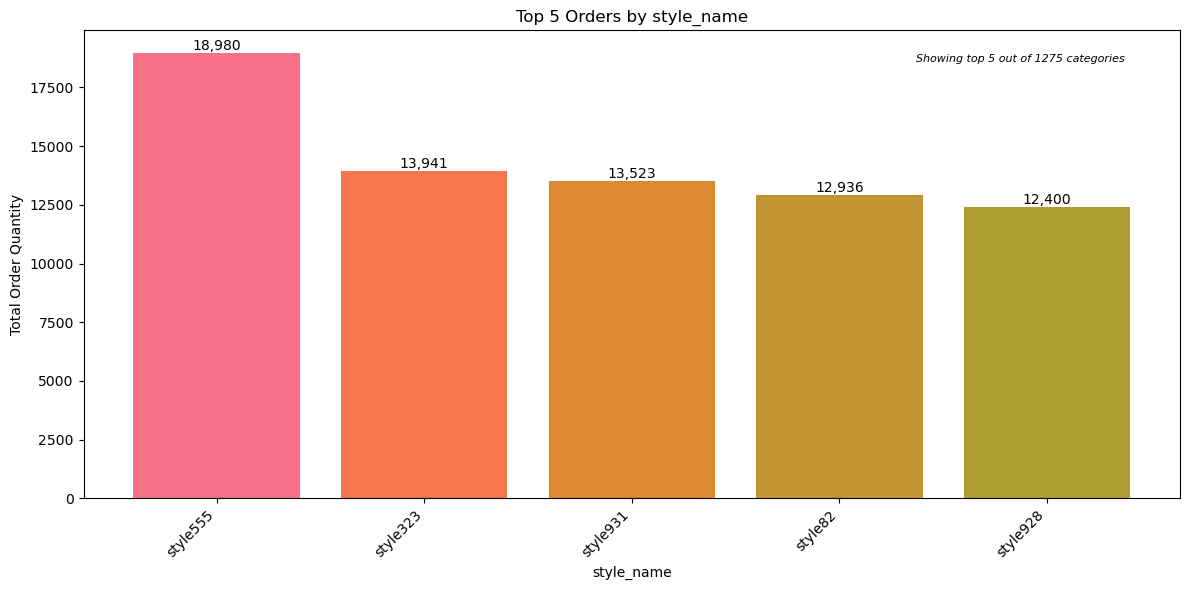

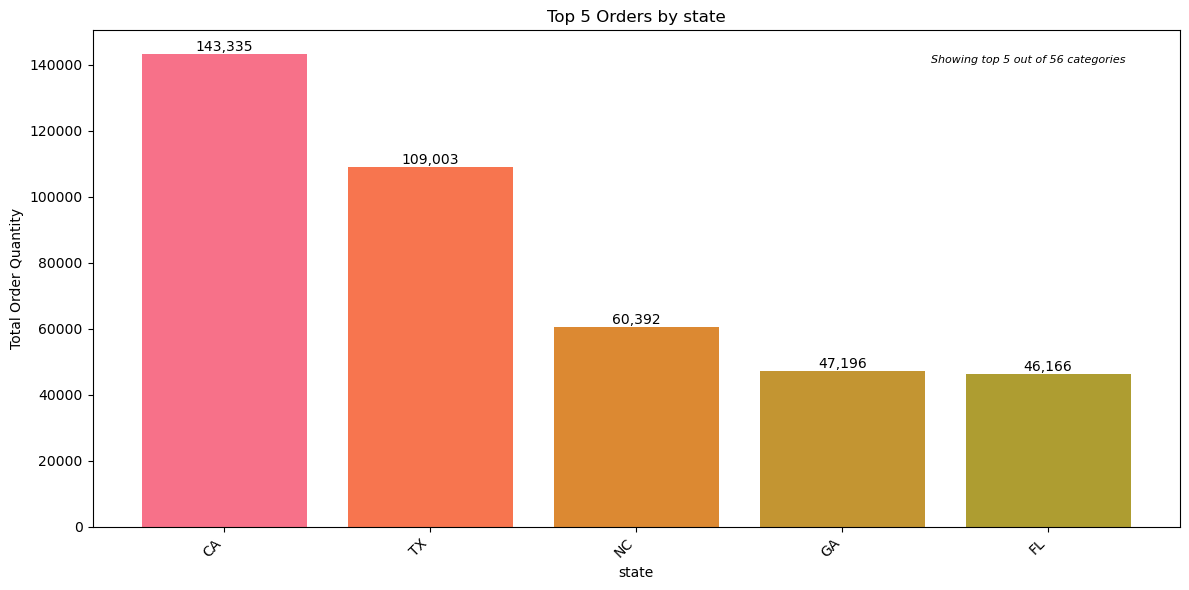

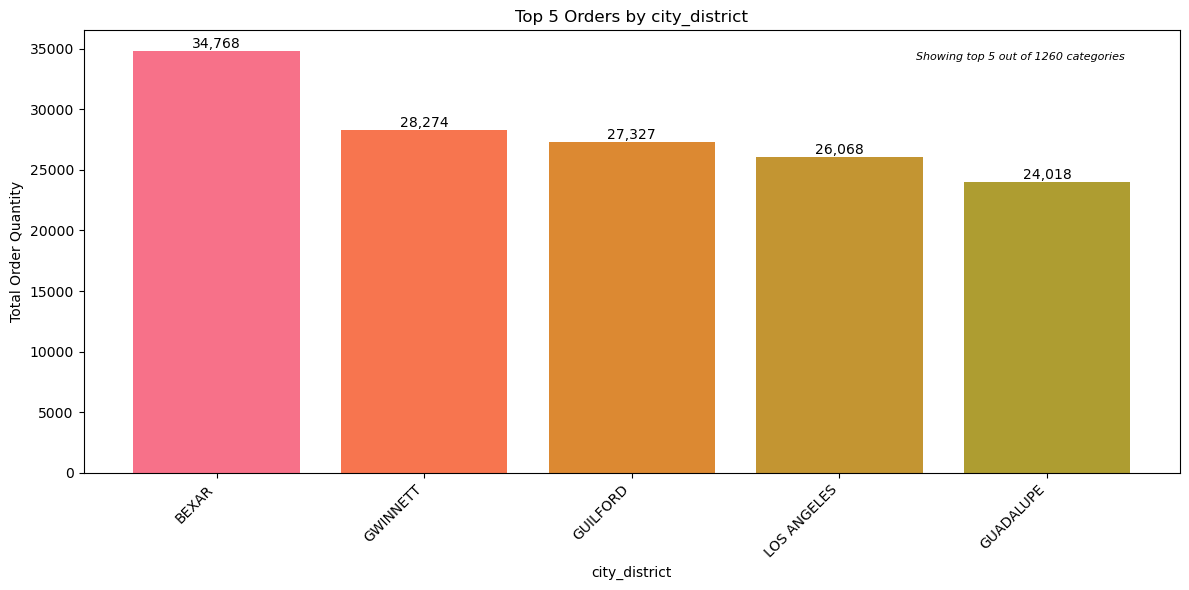

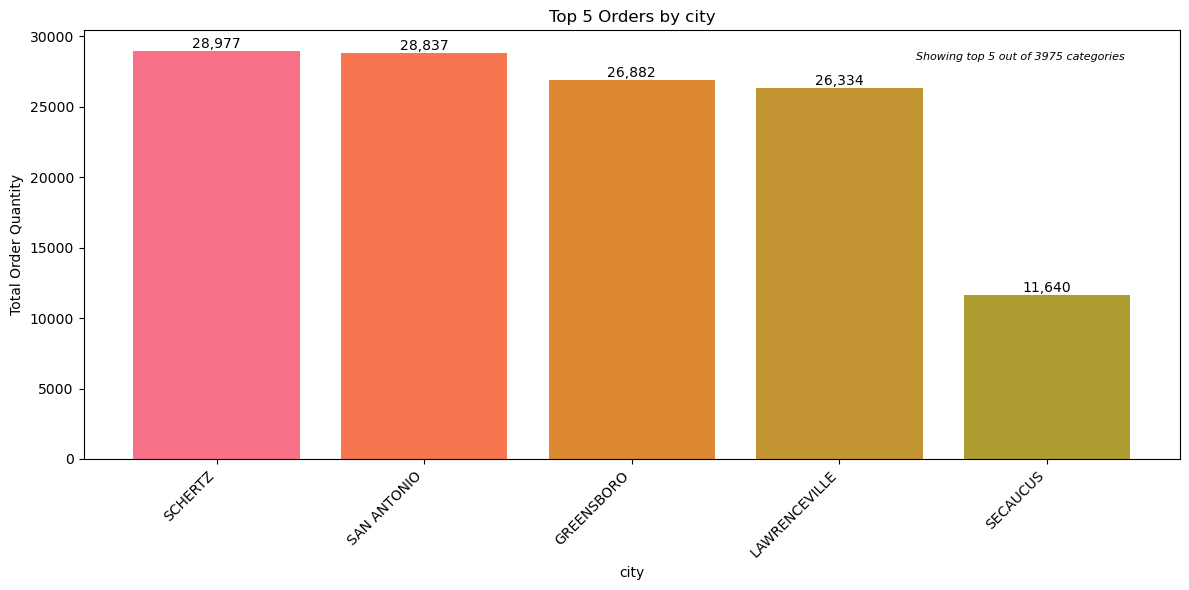

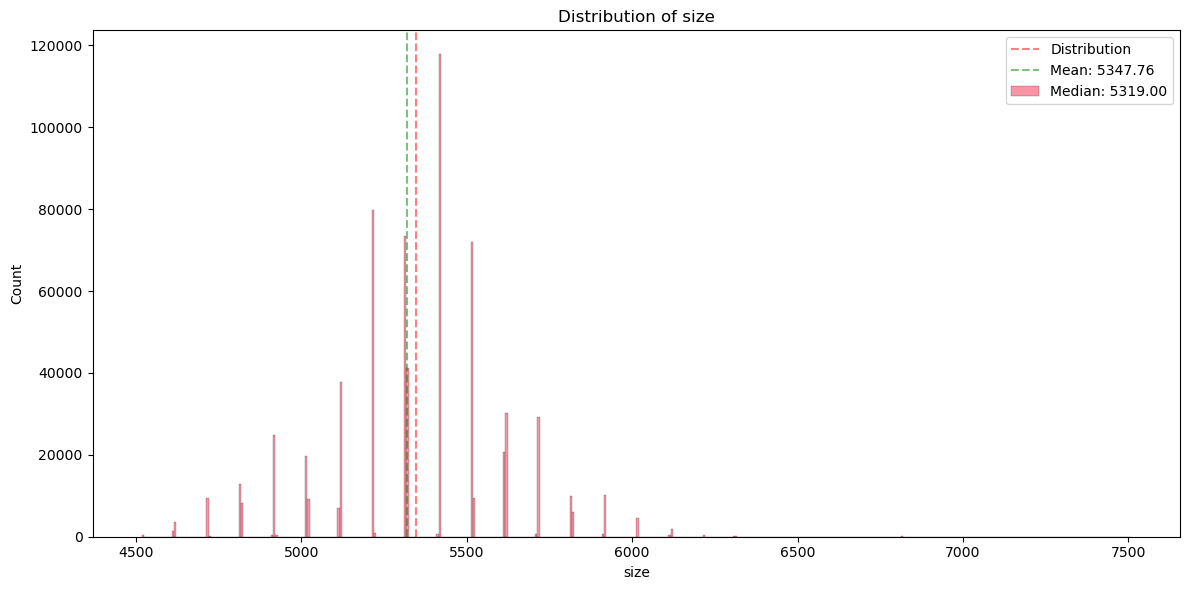

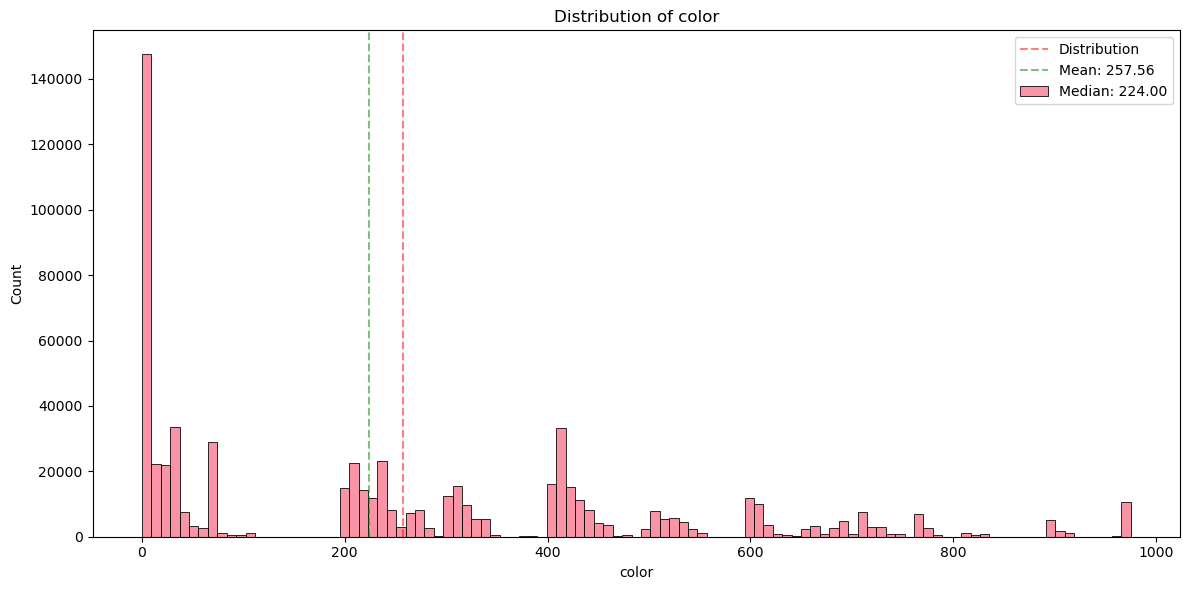

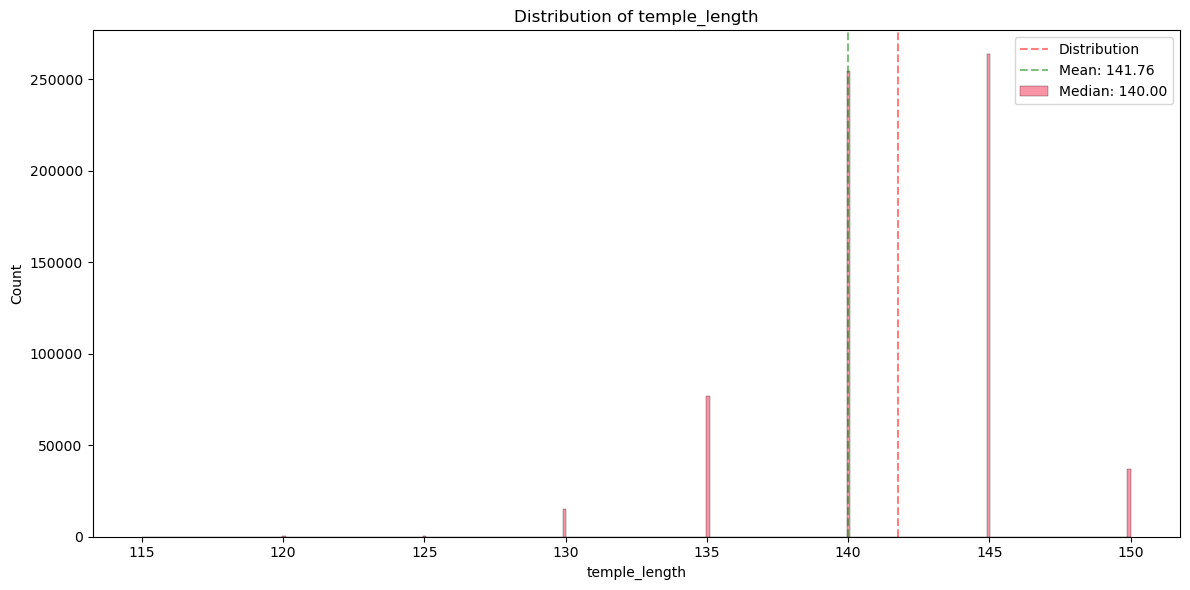

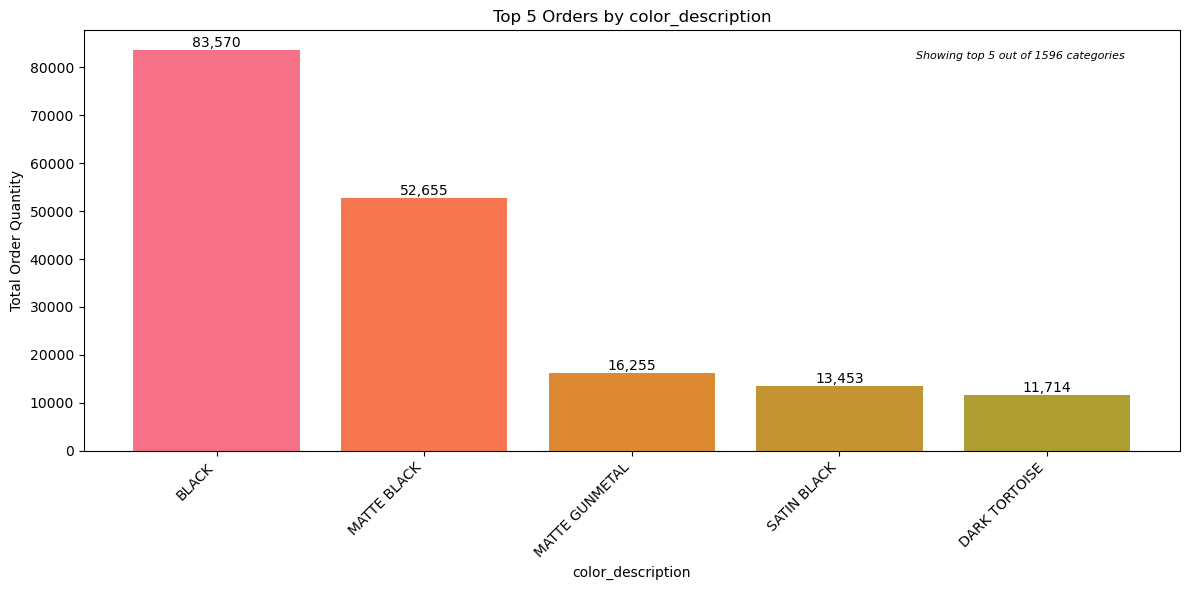

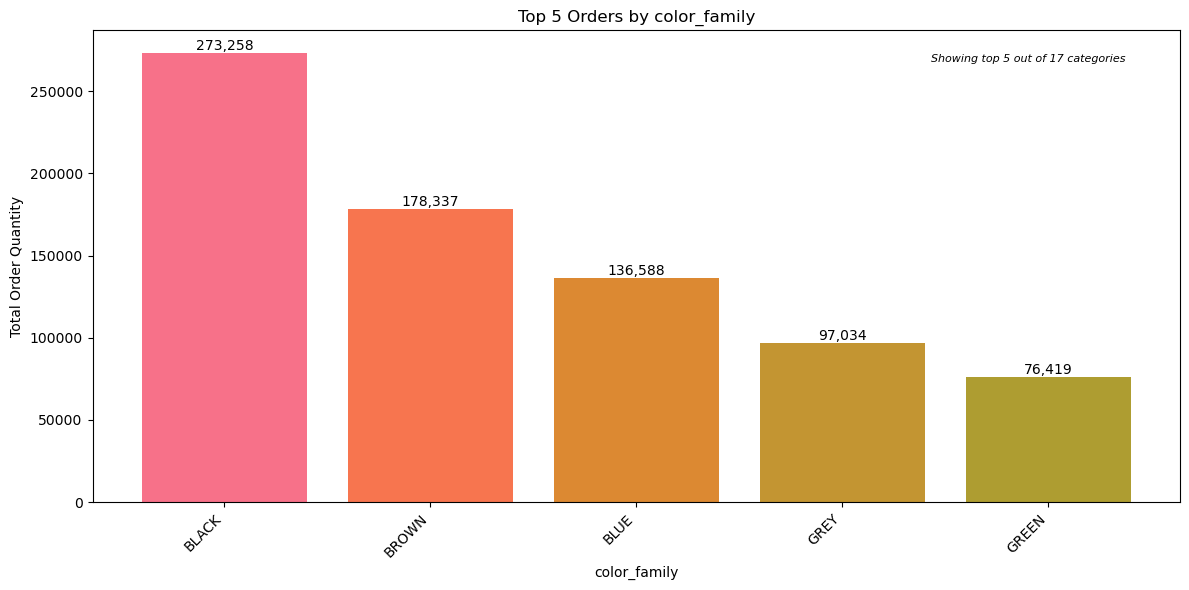

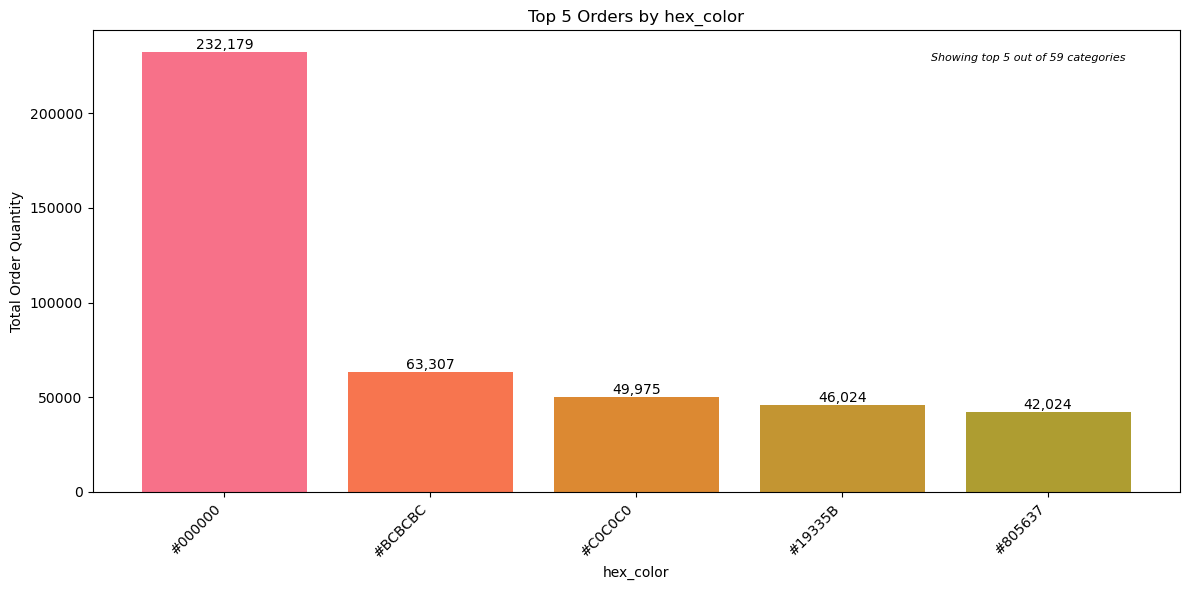

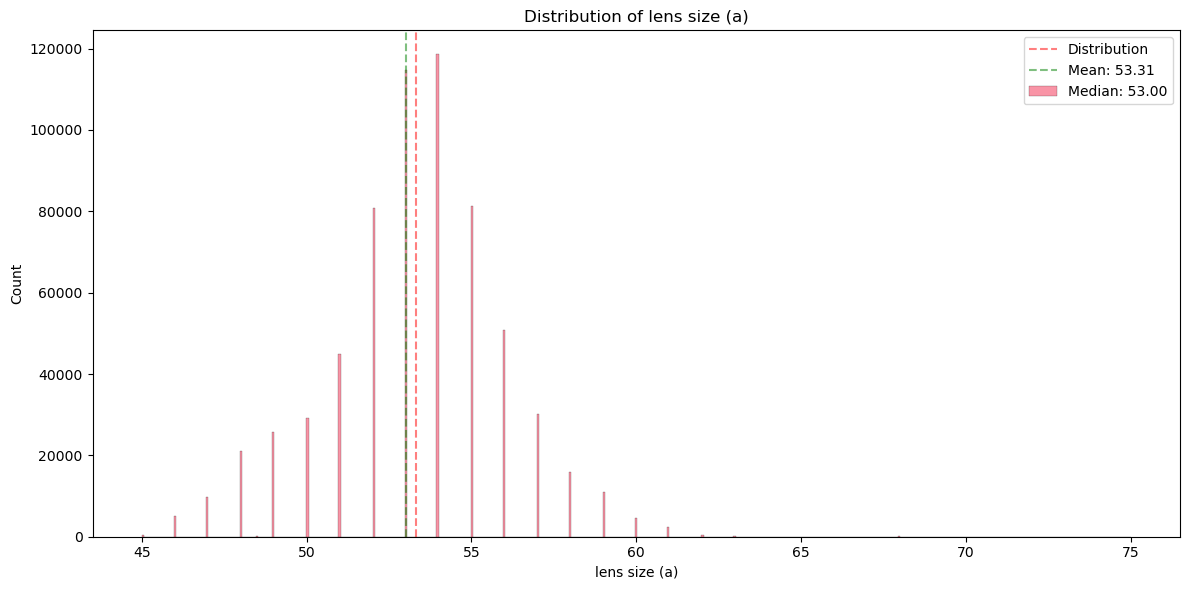

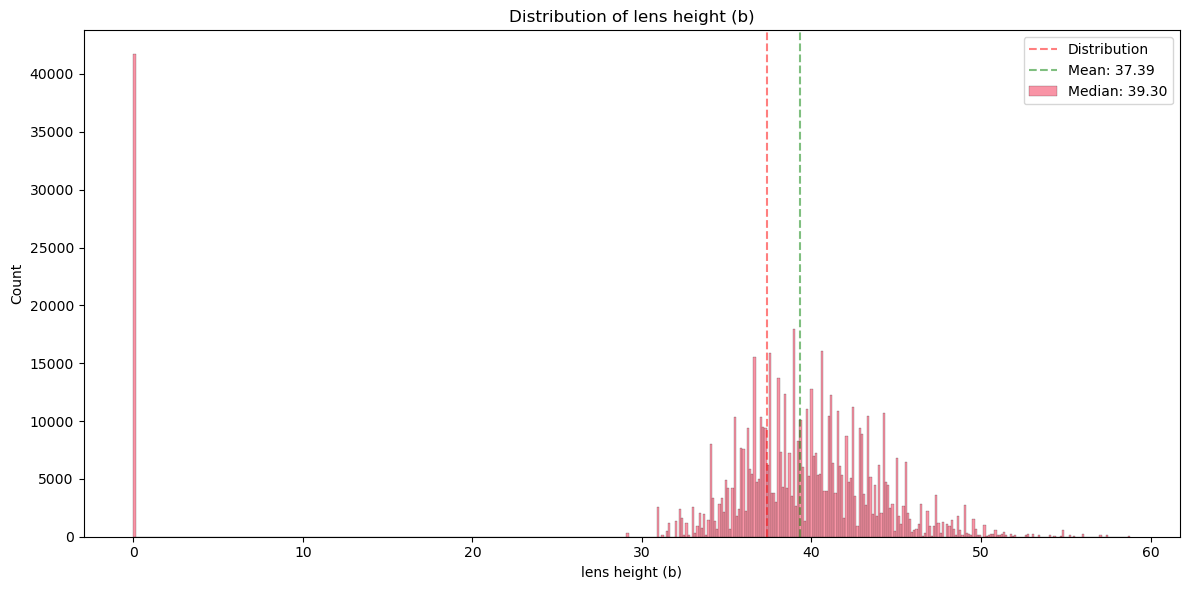

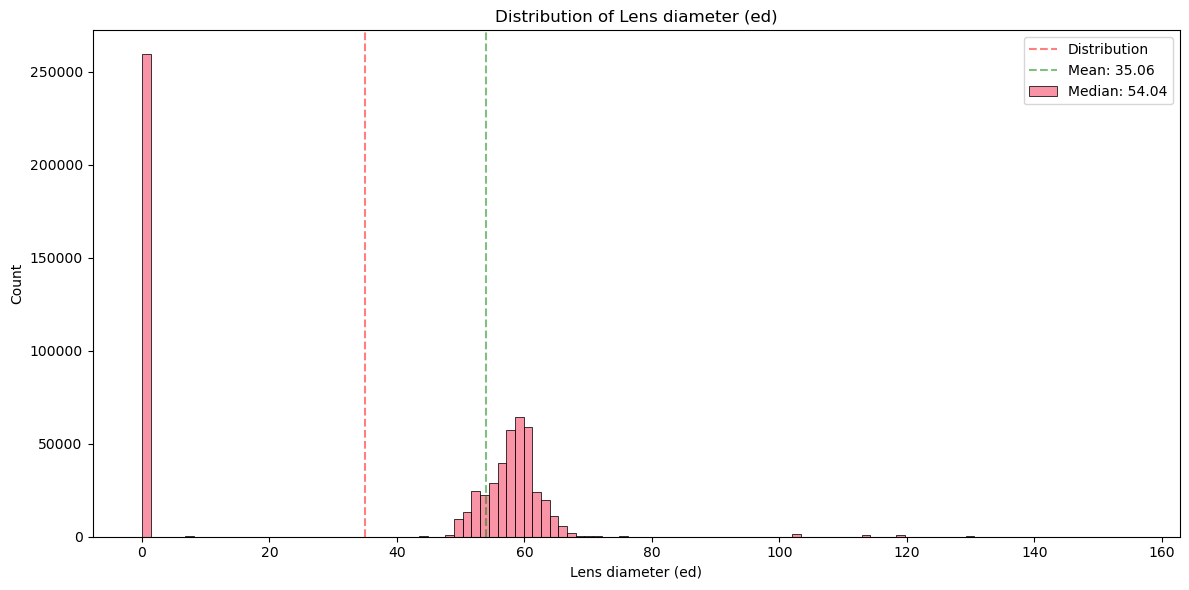

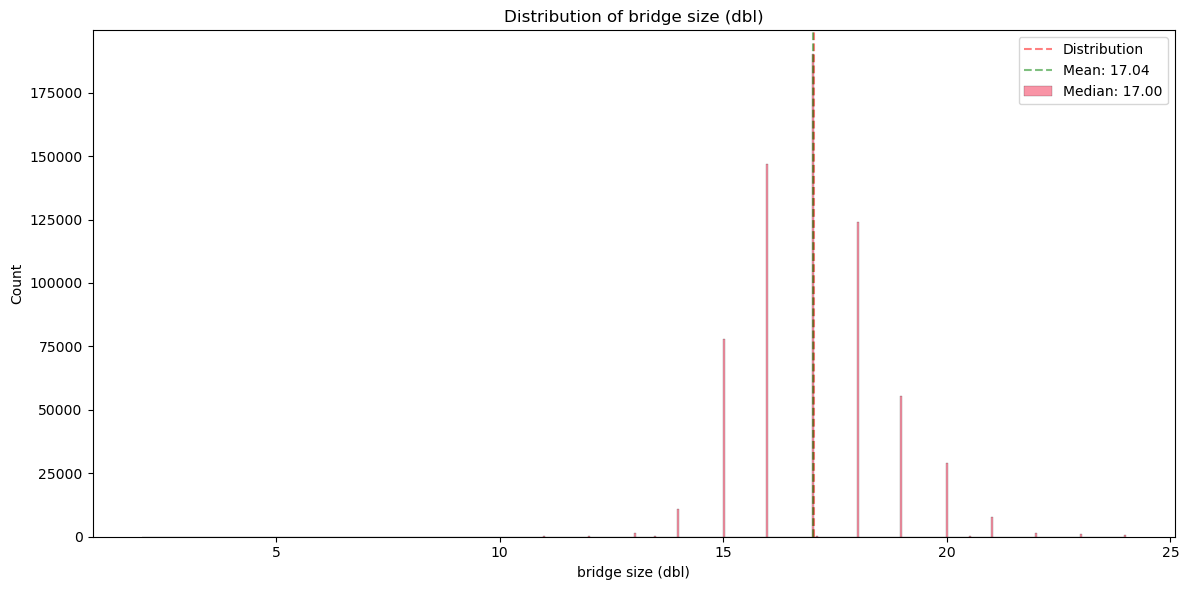

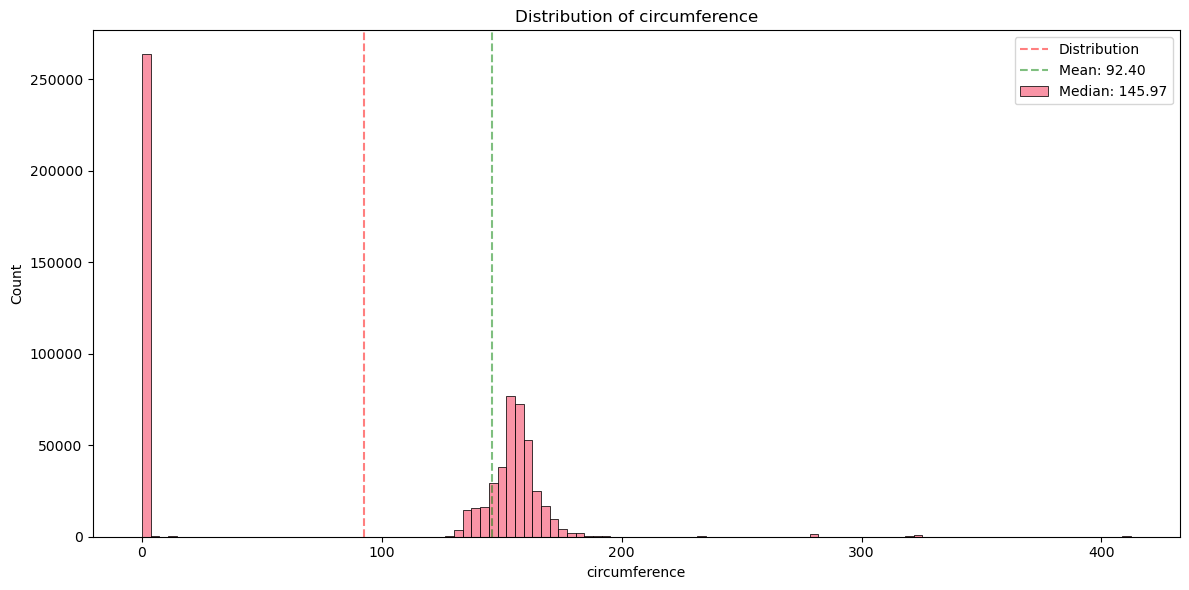

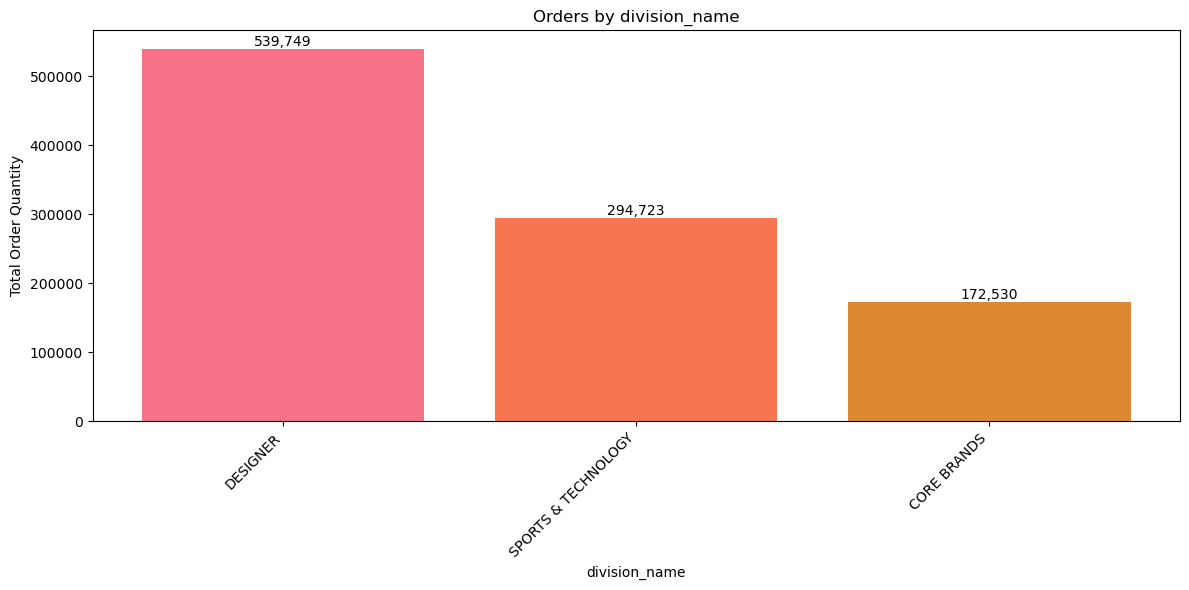

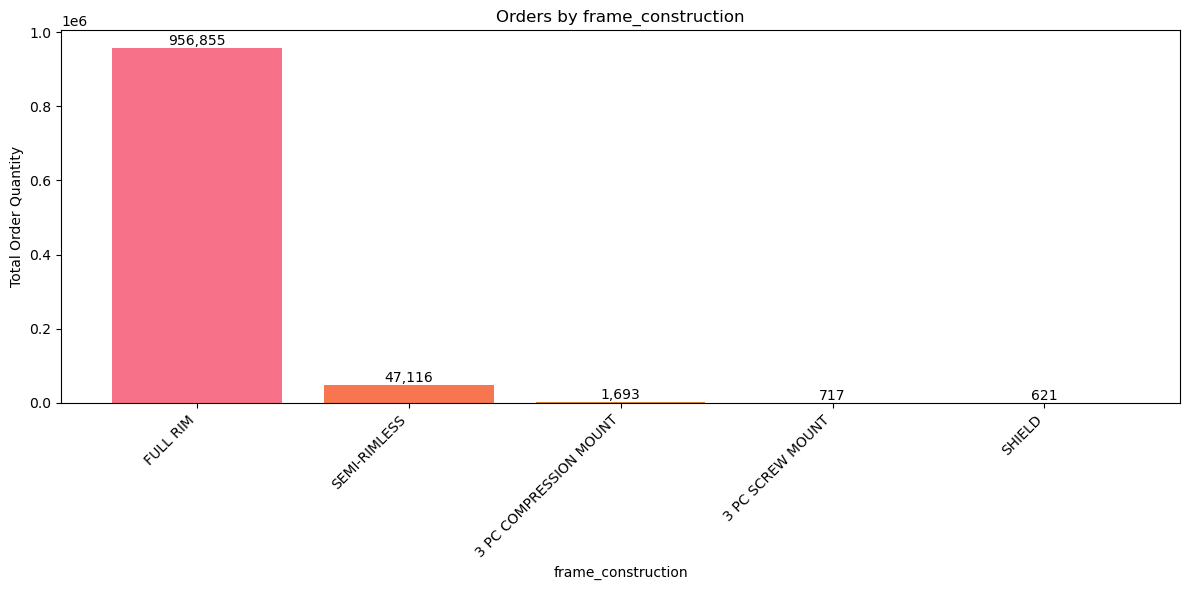

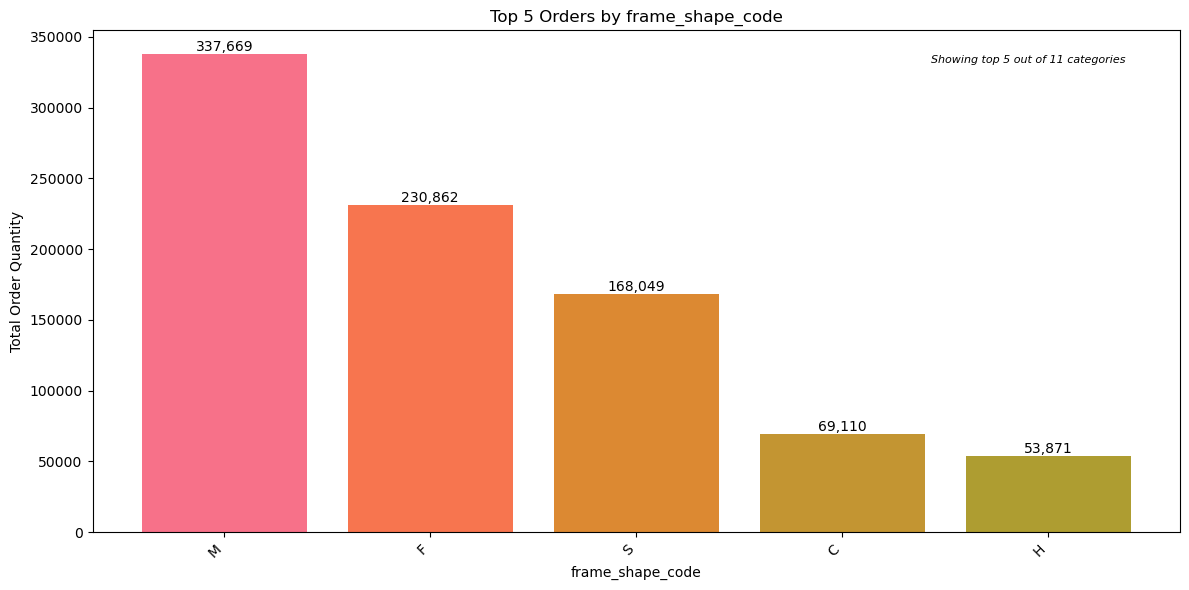

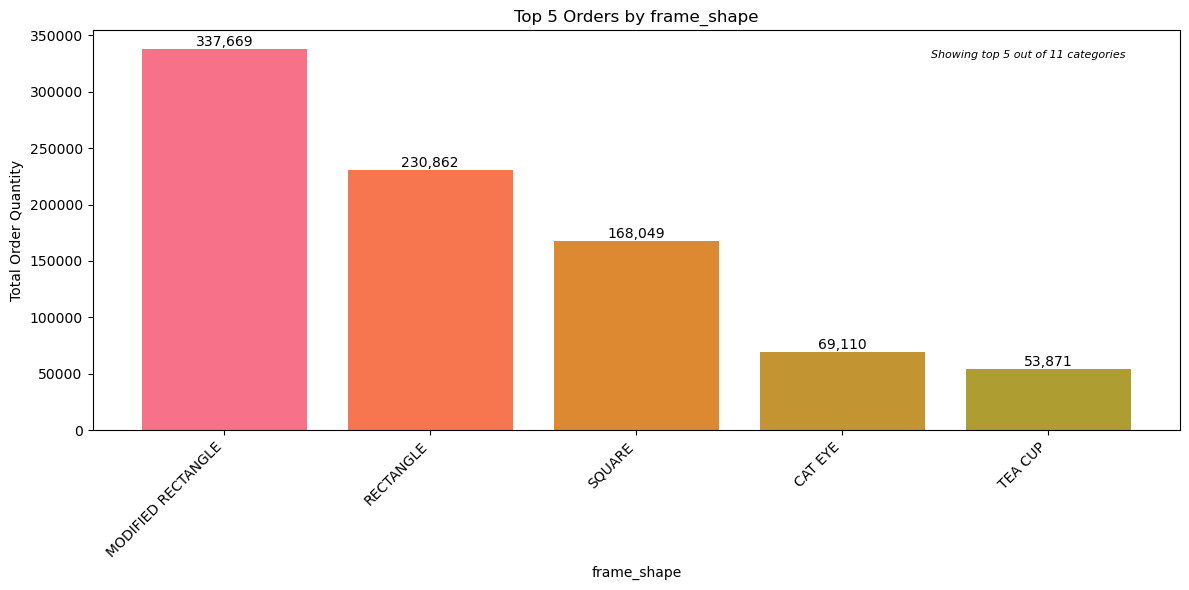

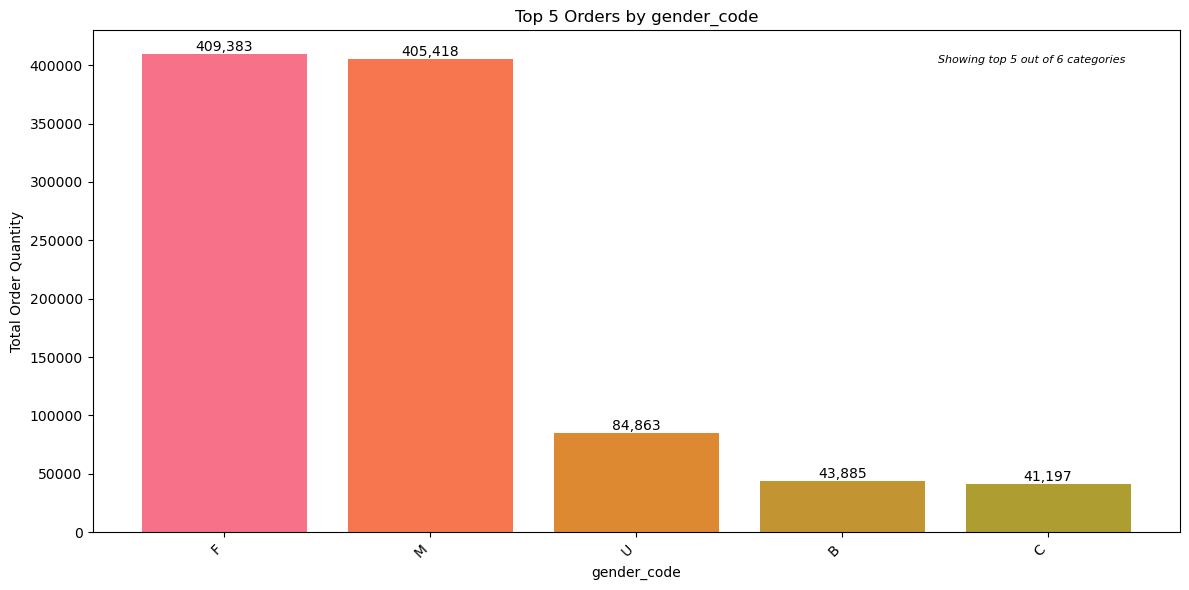

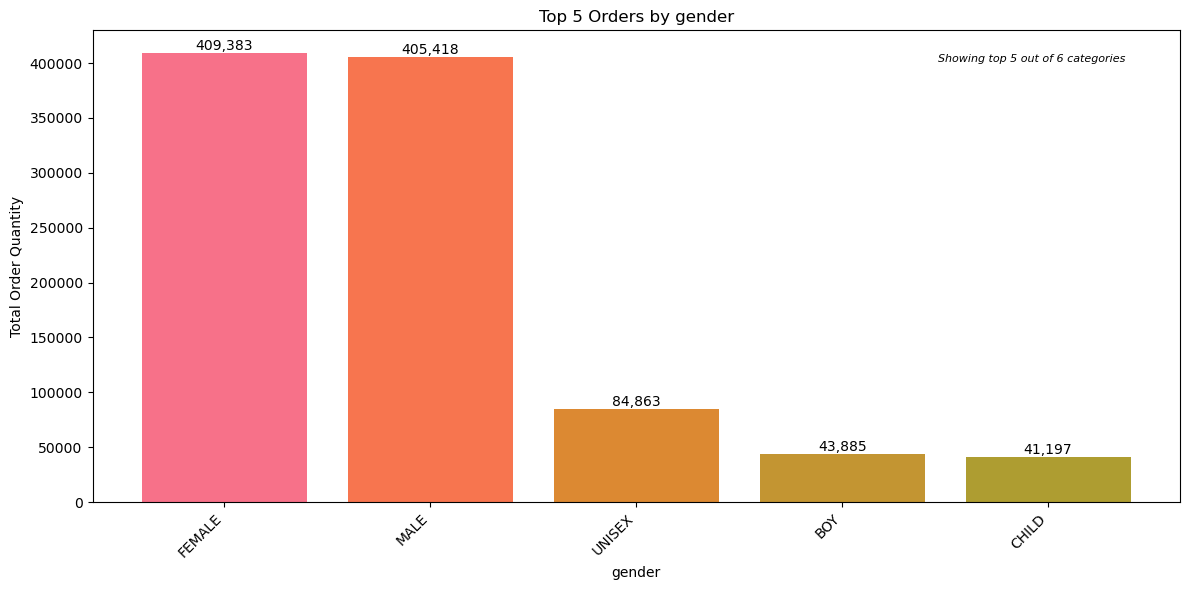

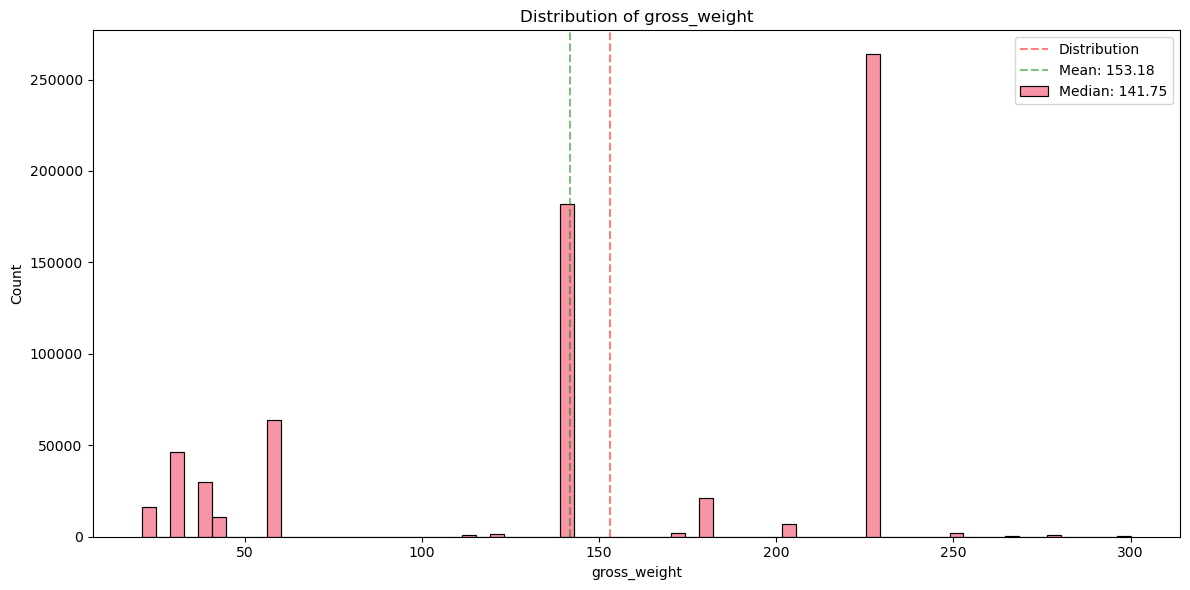

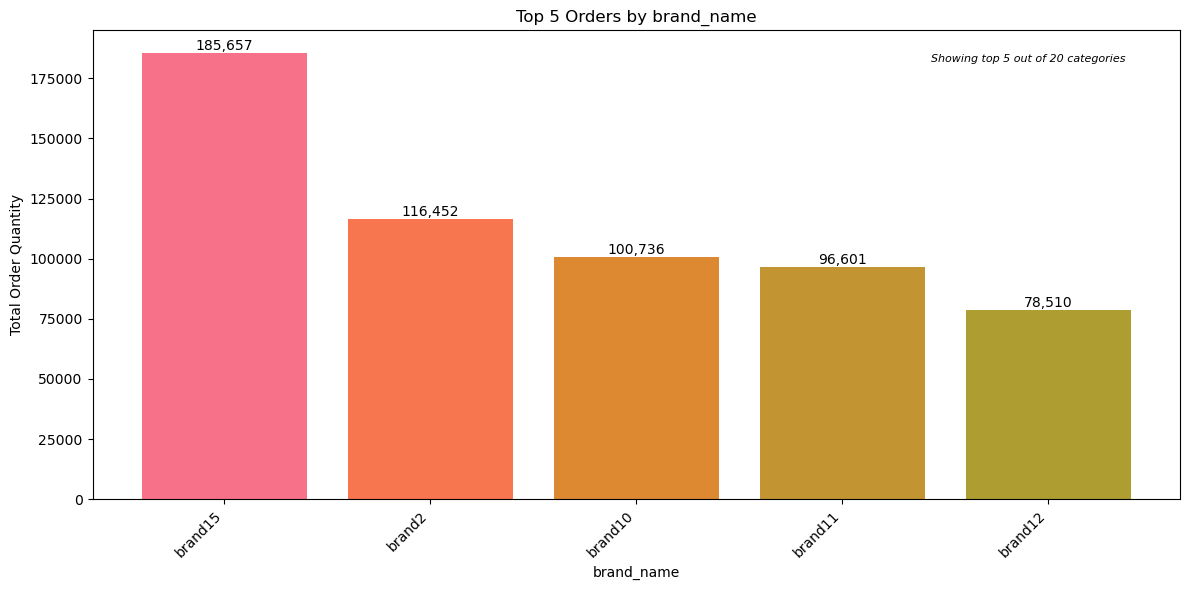

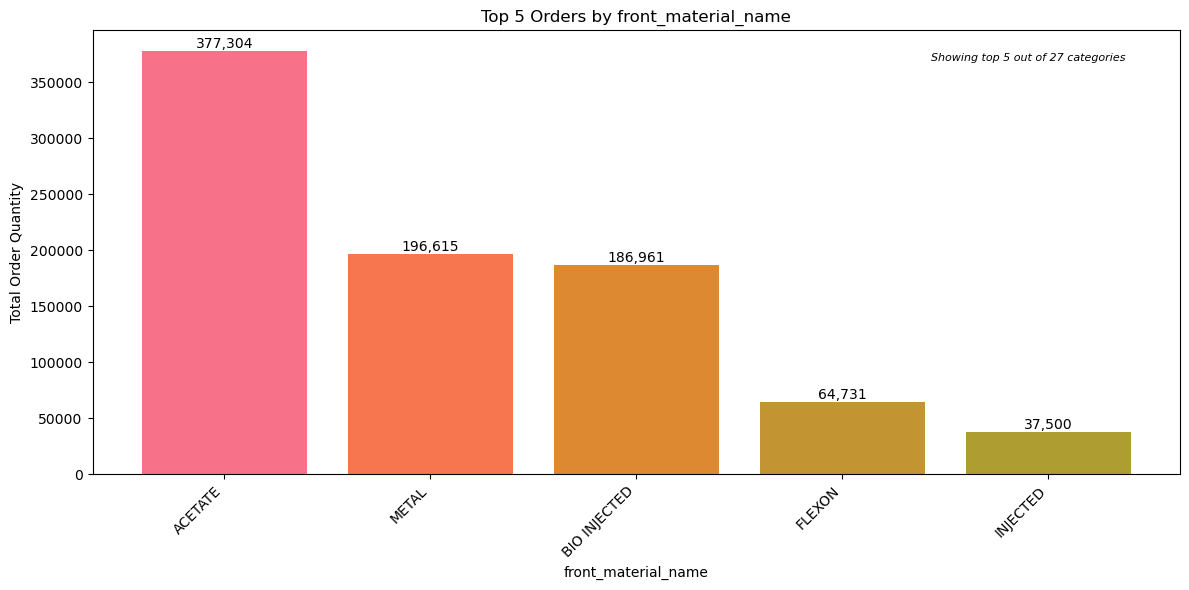

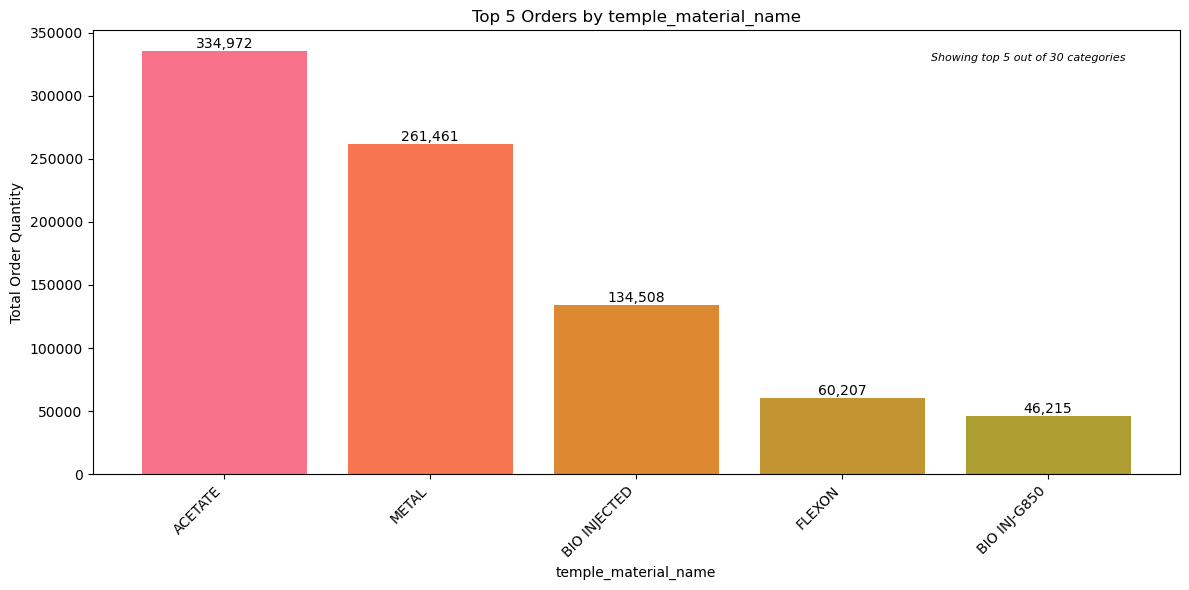

In [6]:
plot_distributions(df)

## Analysis: Preferences / Orders by Staet

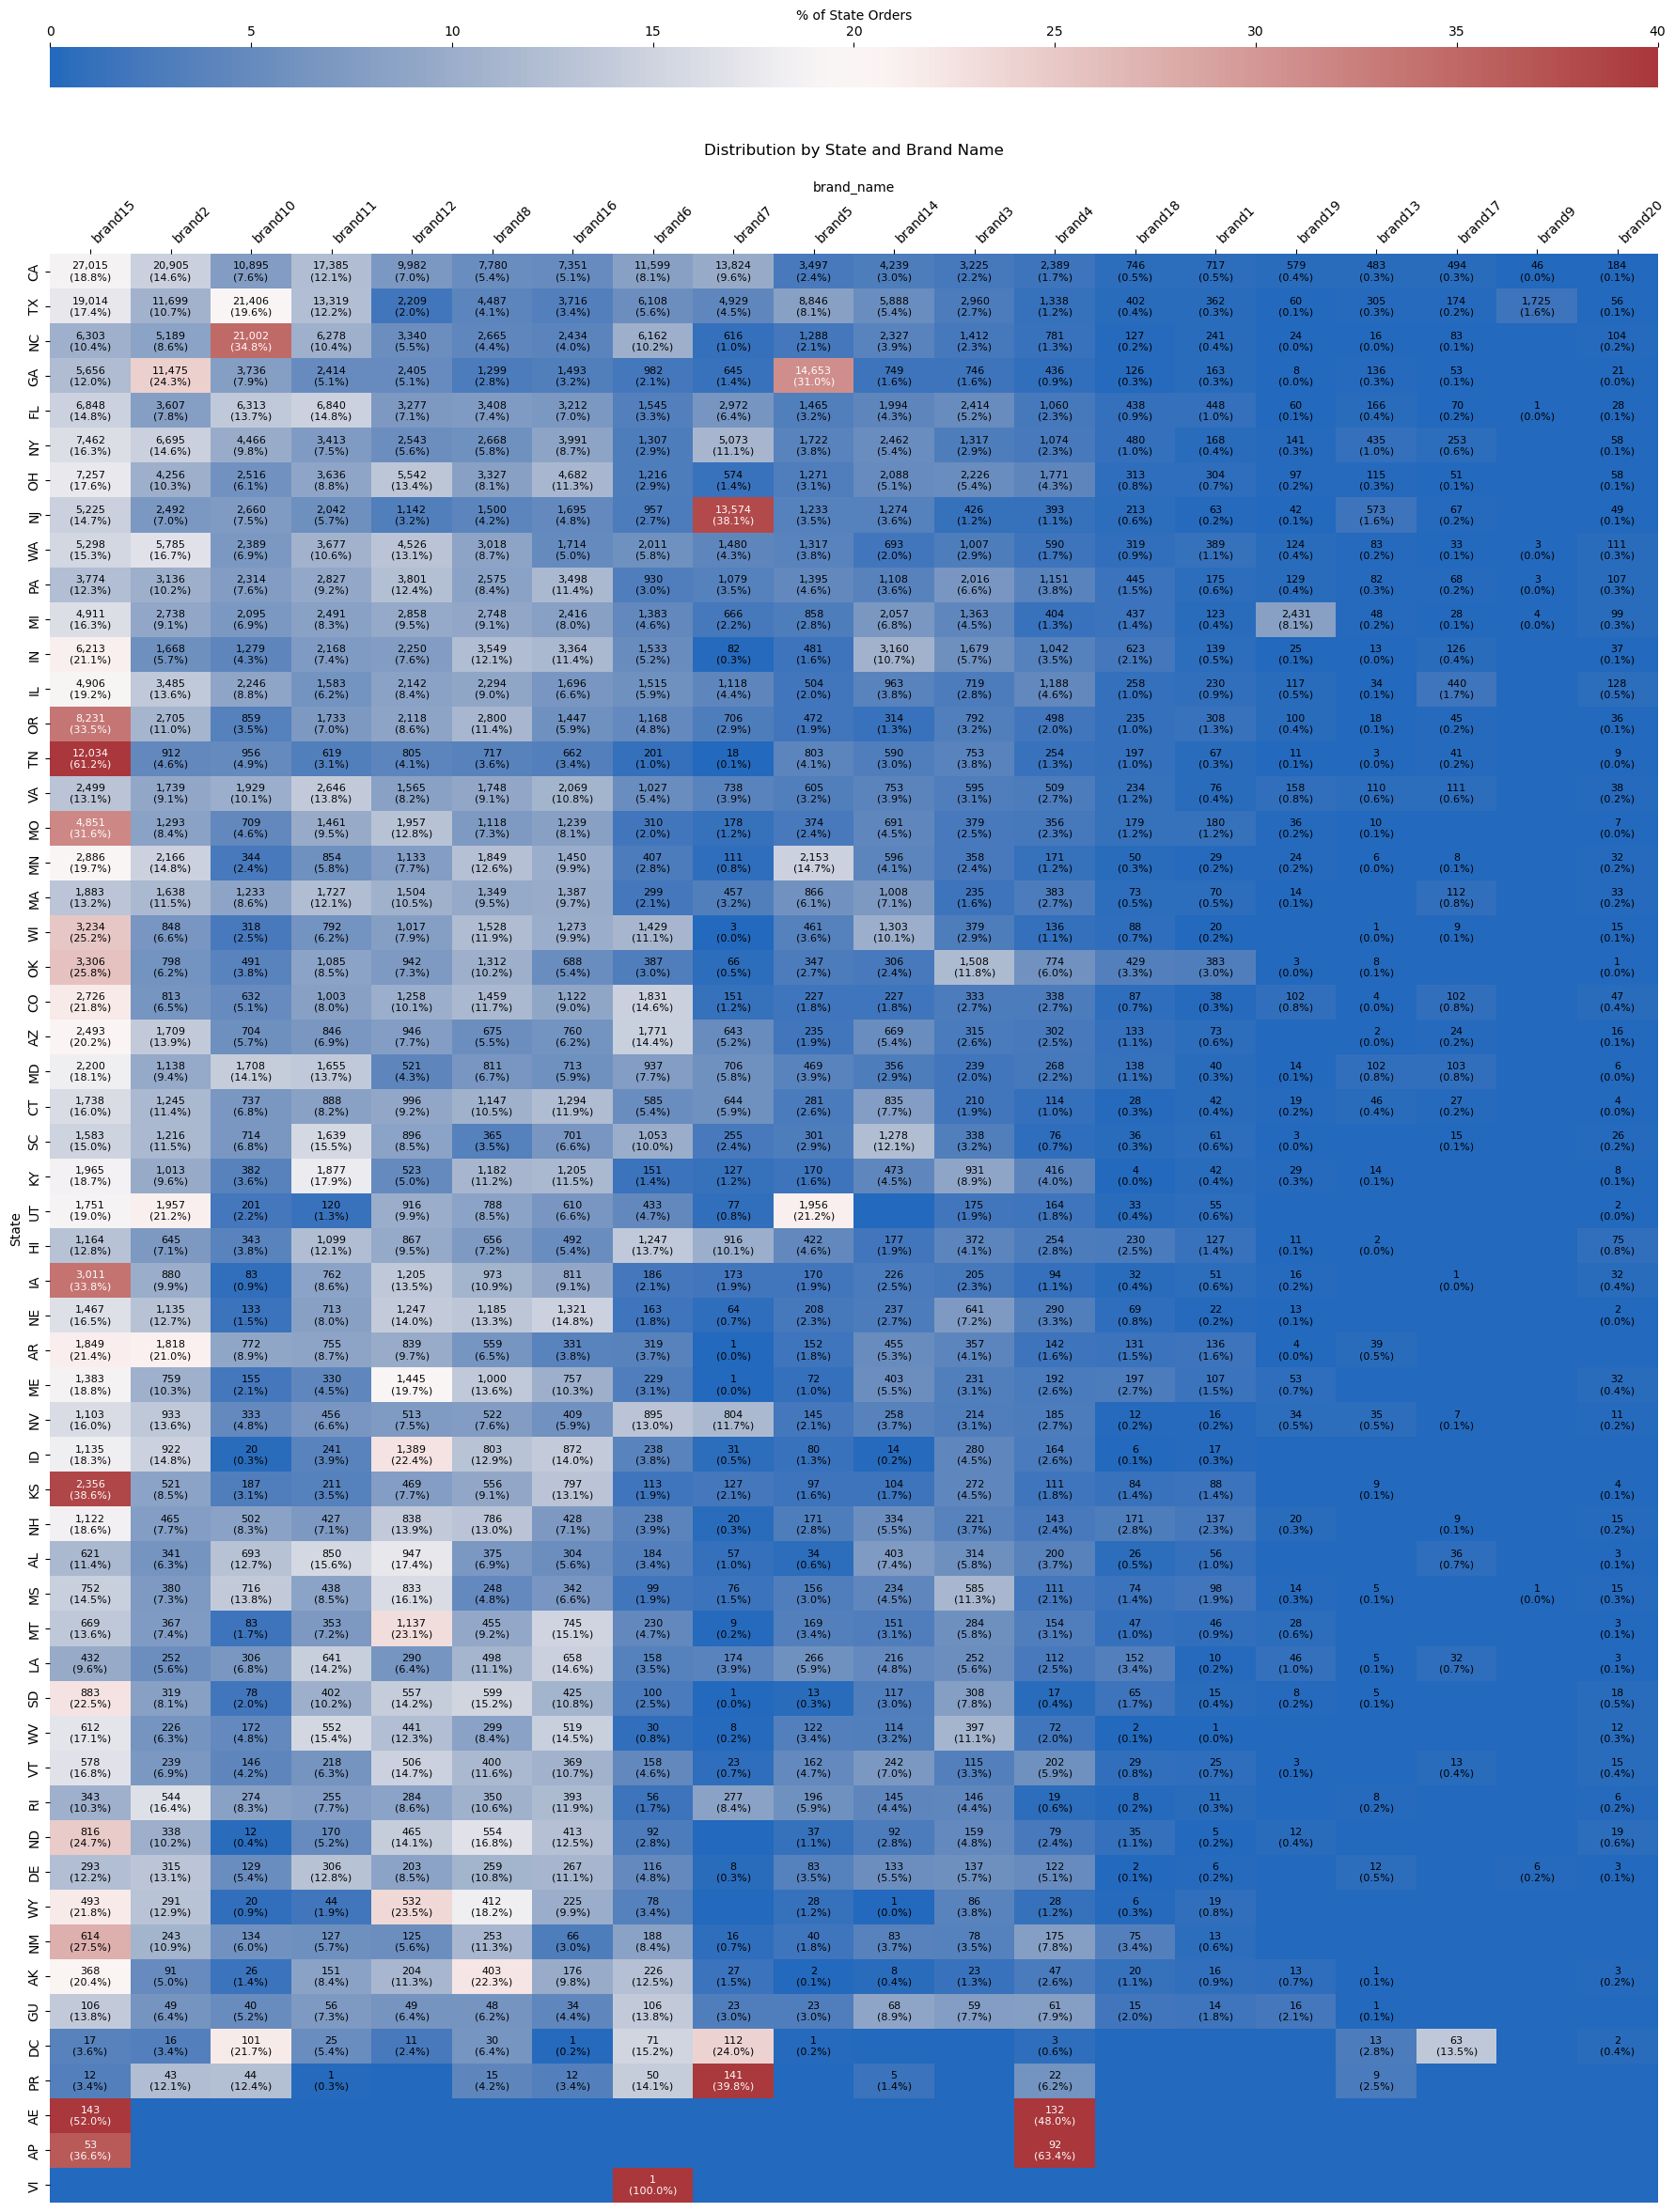

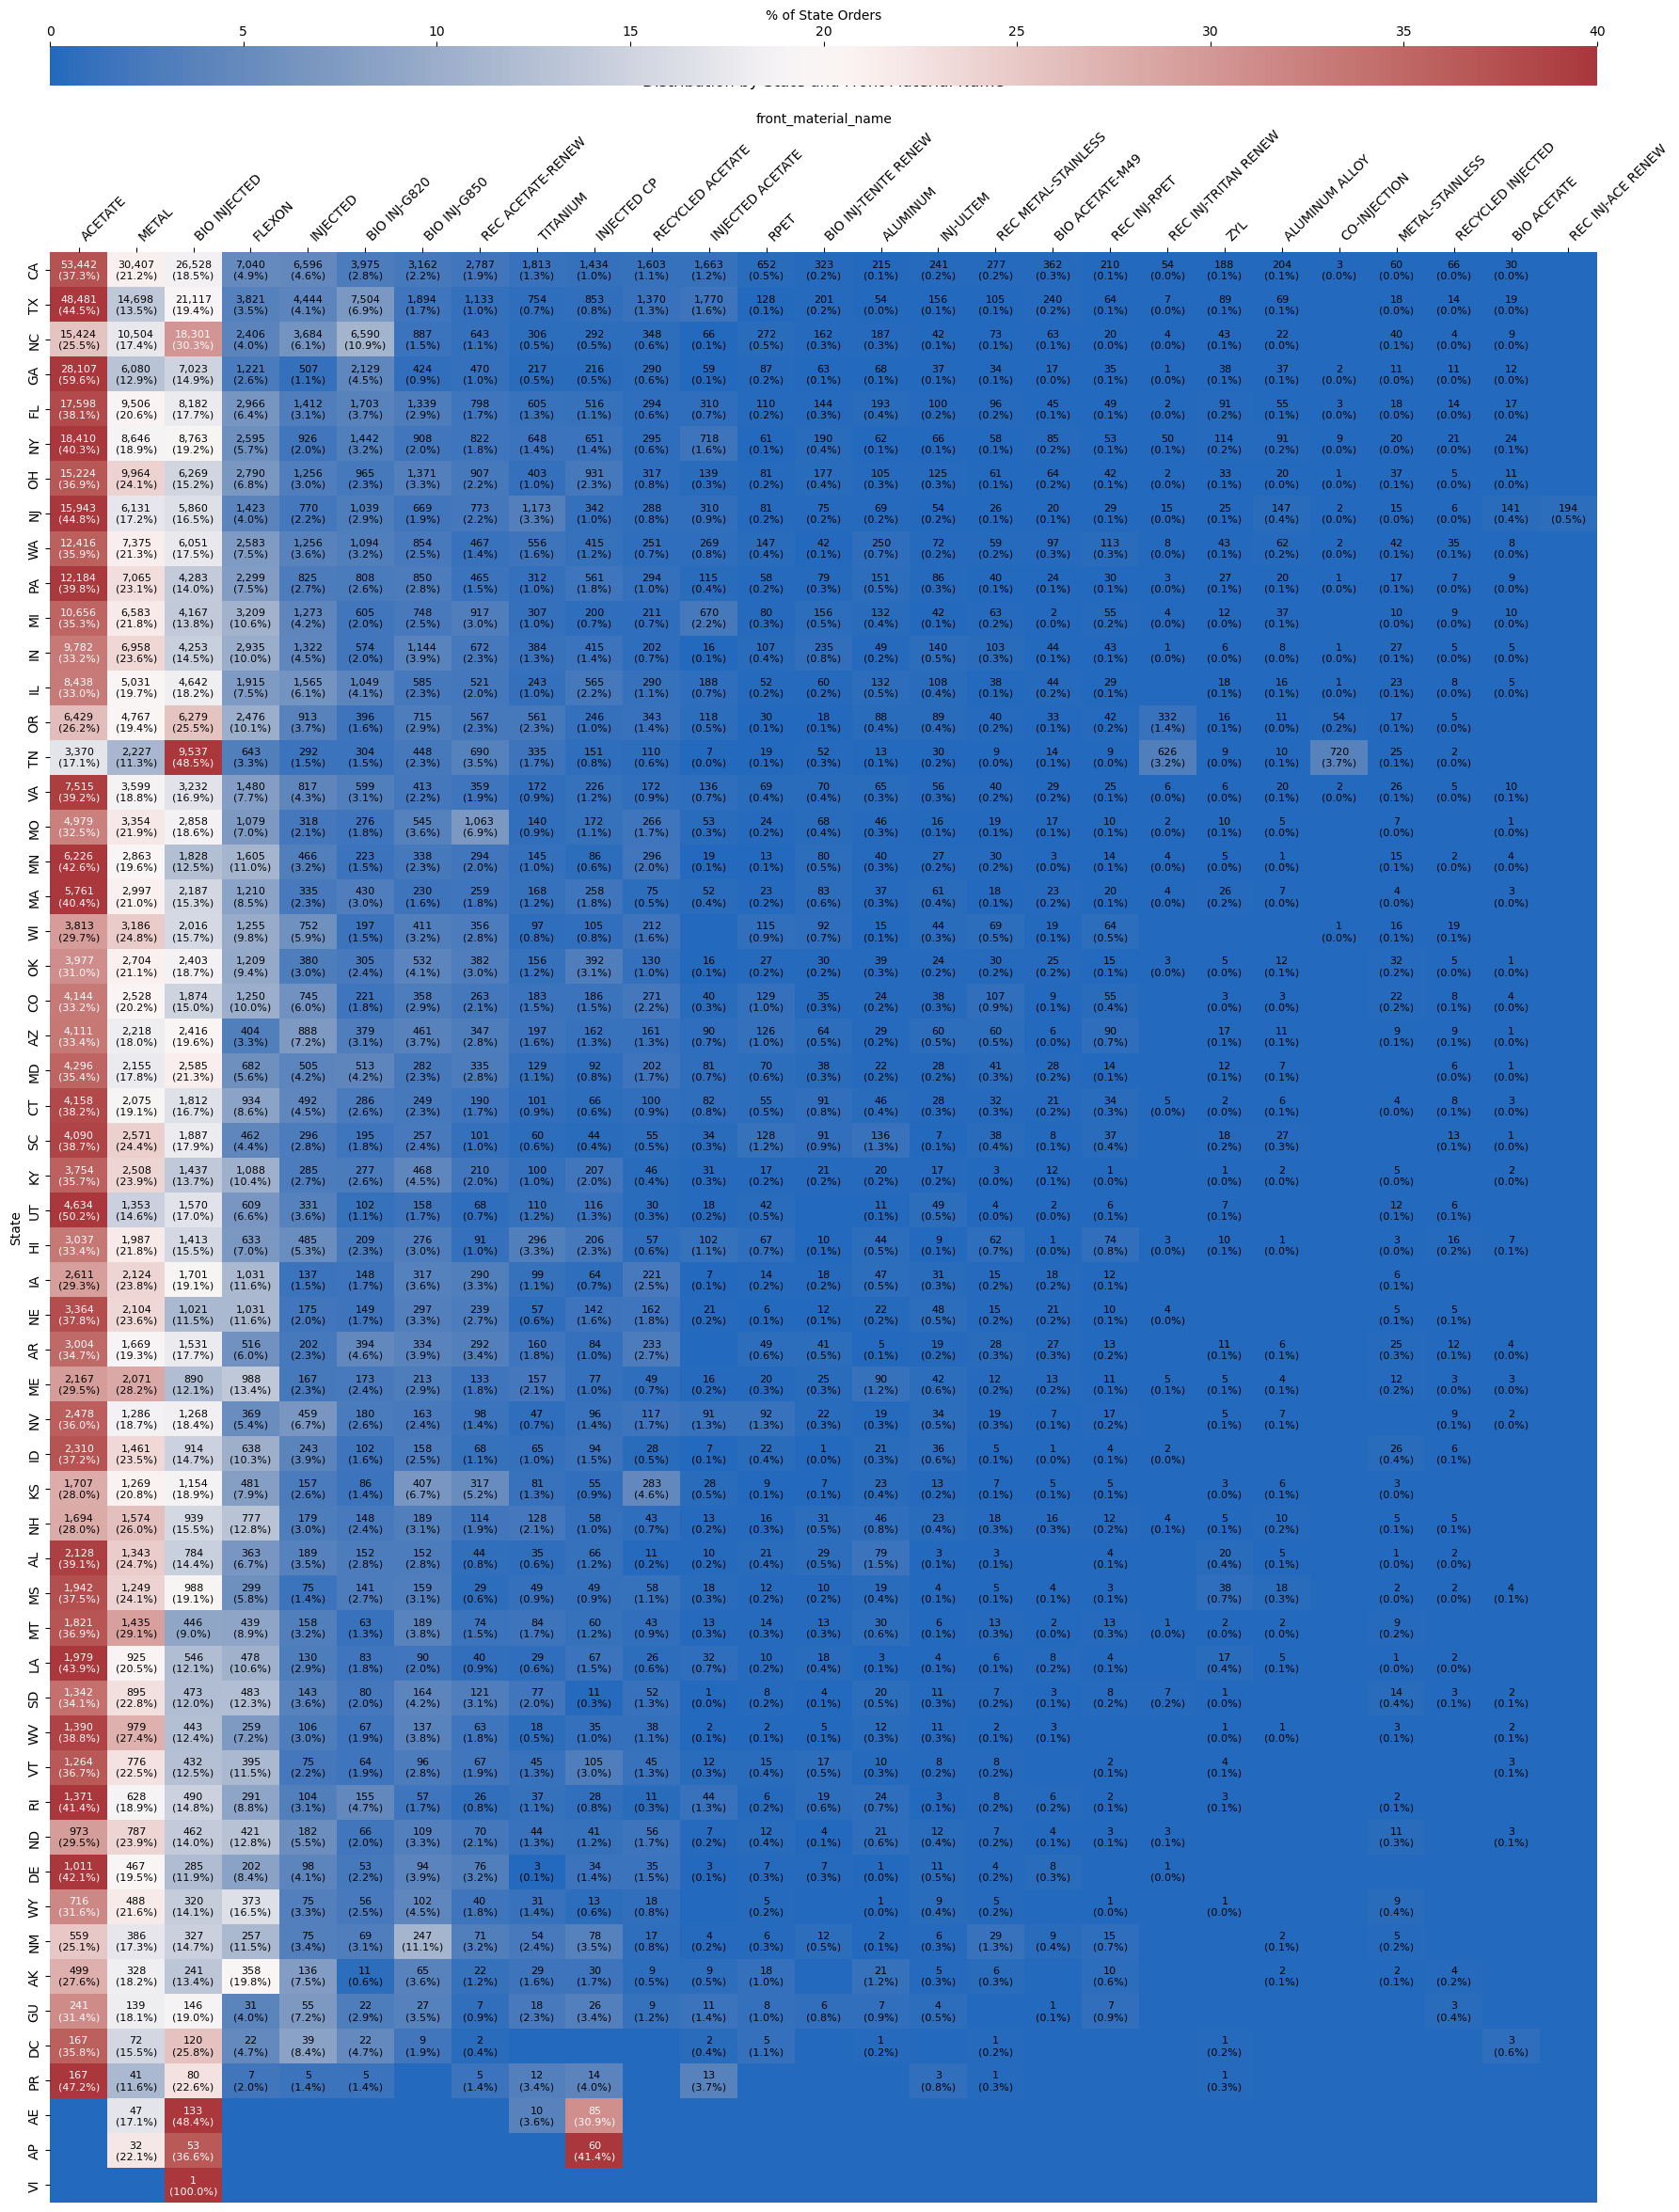

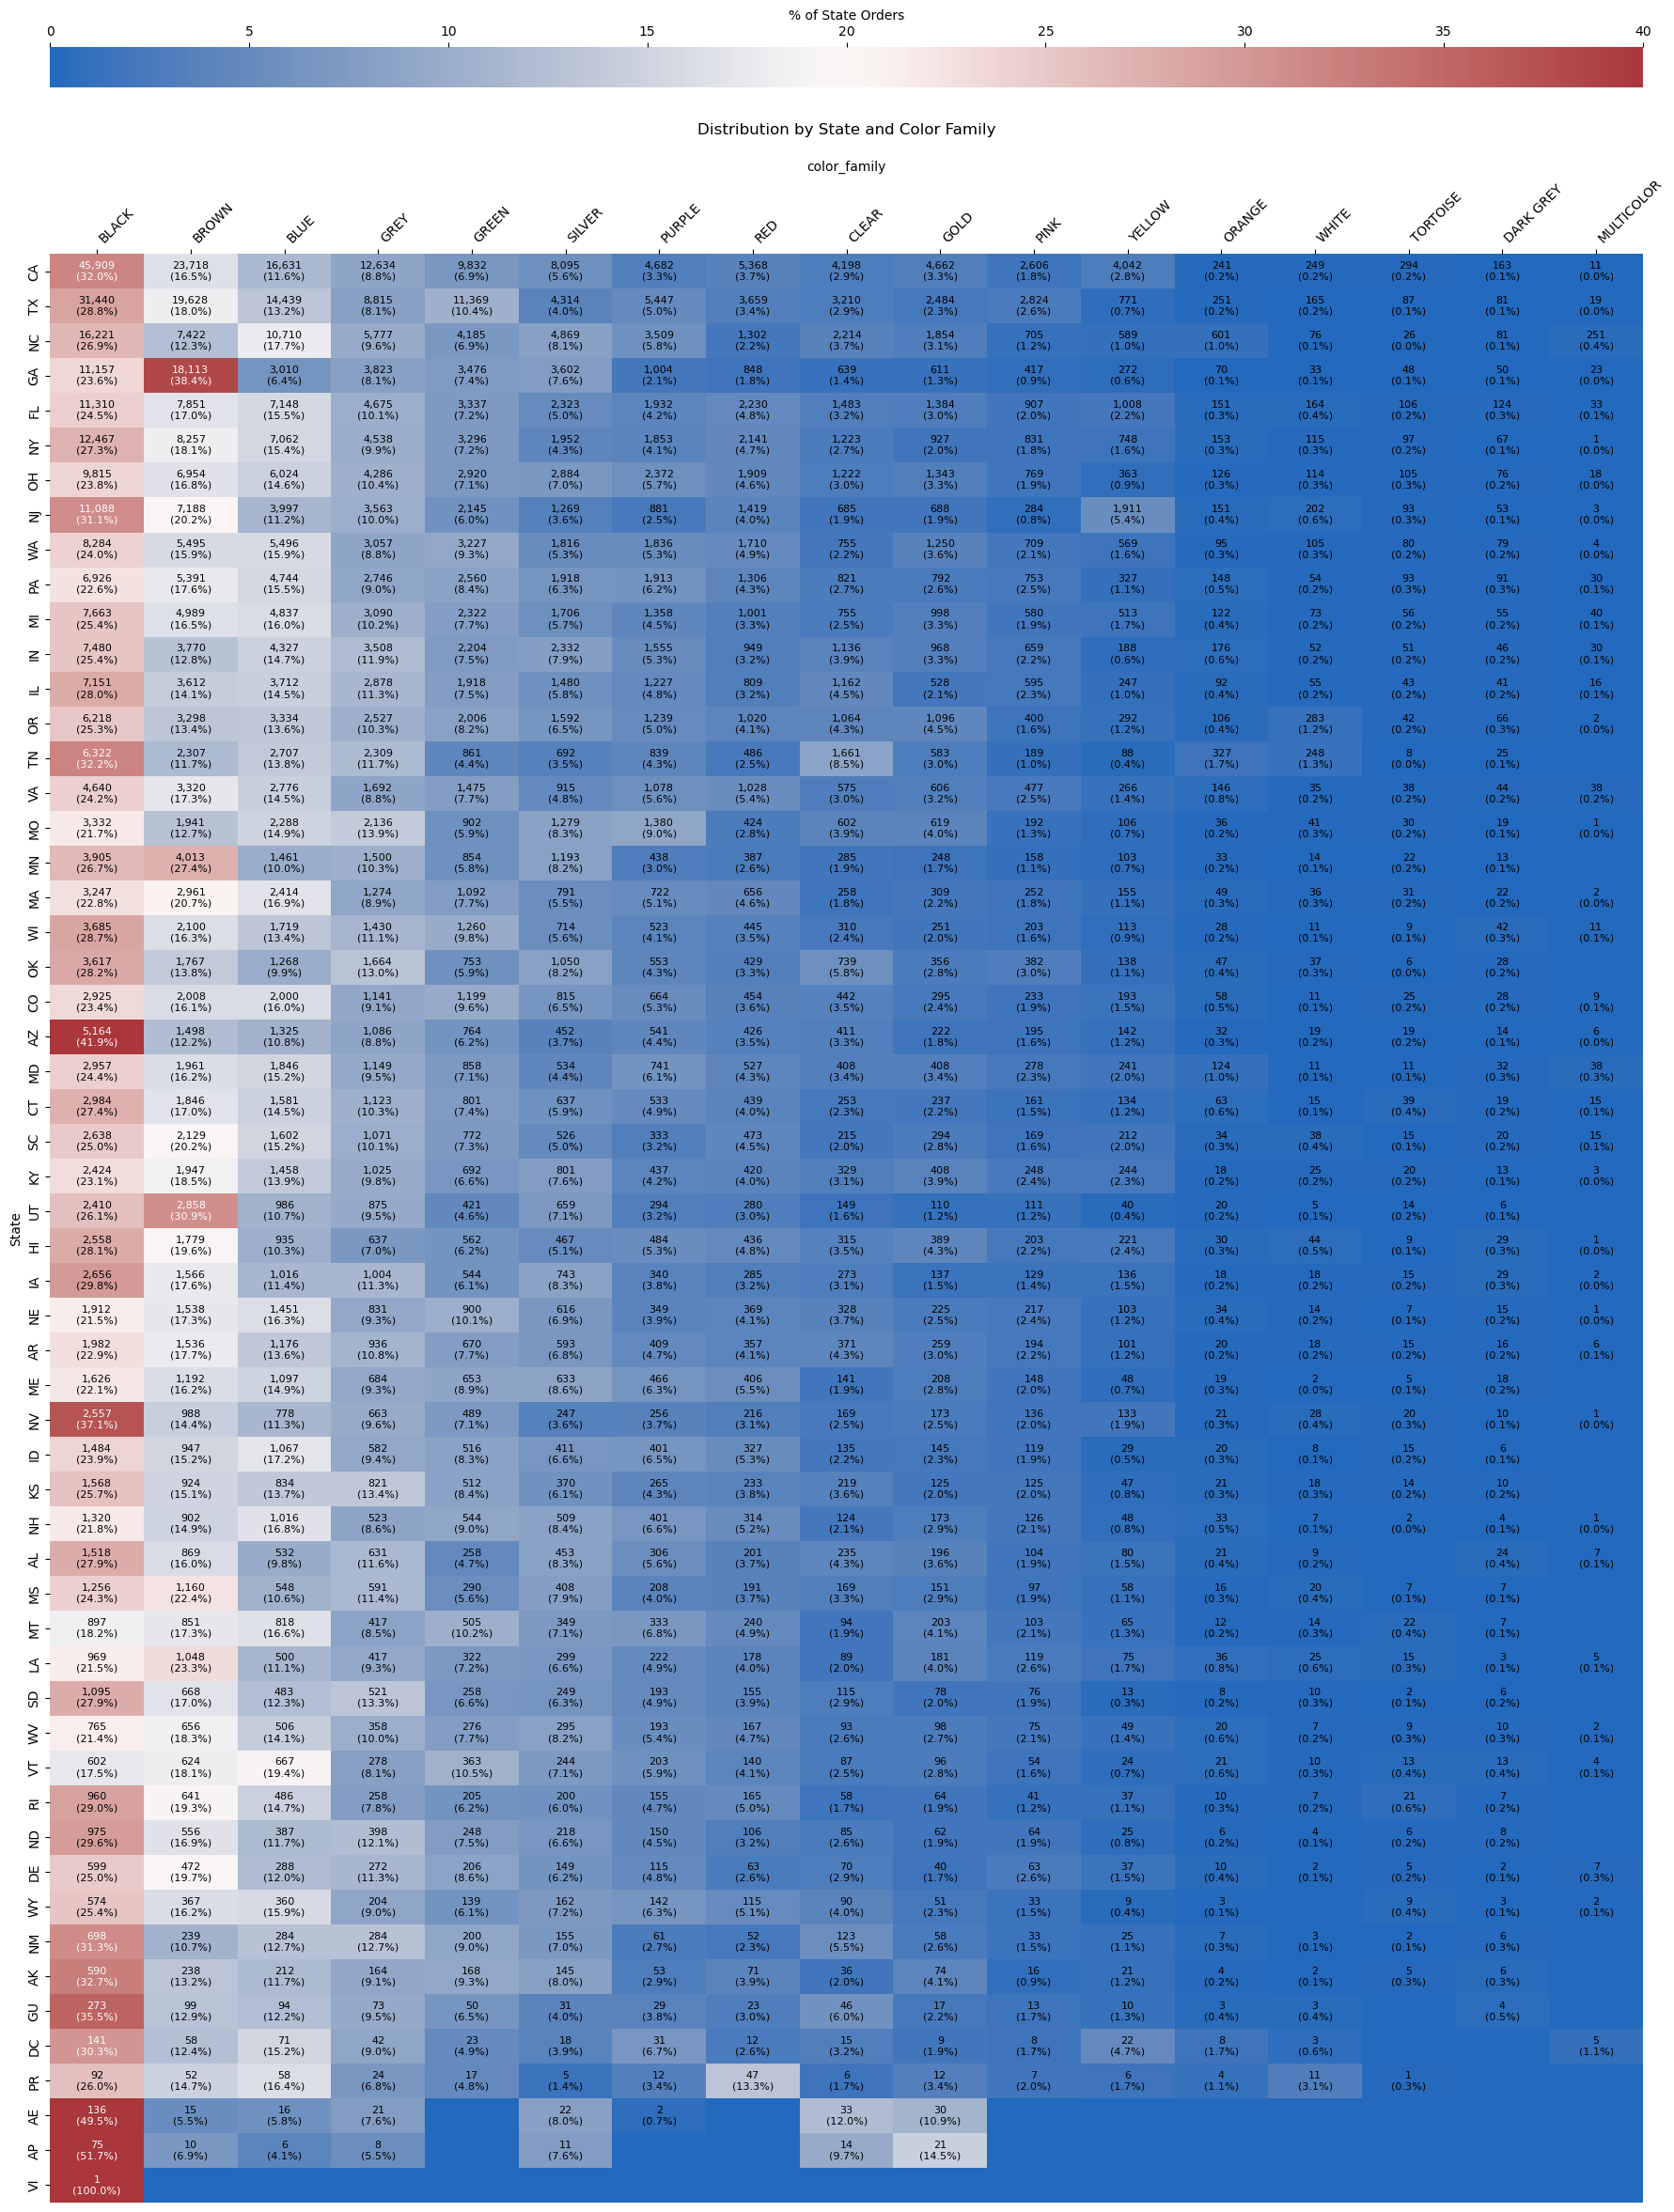

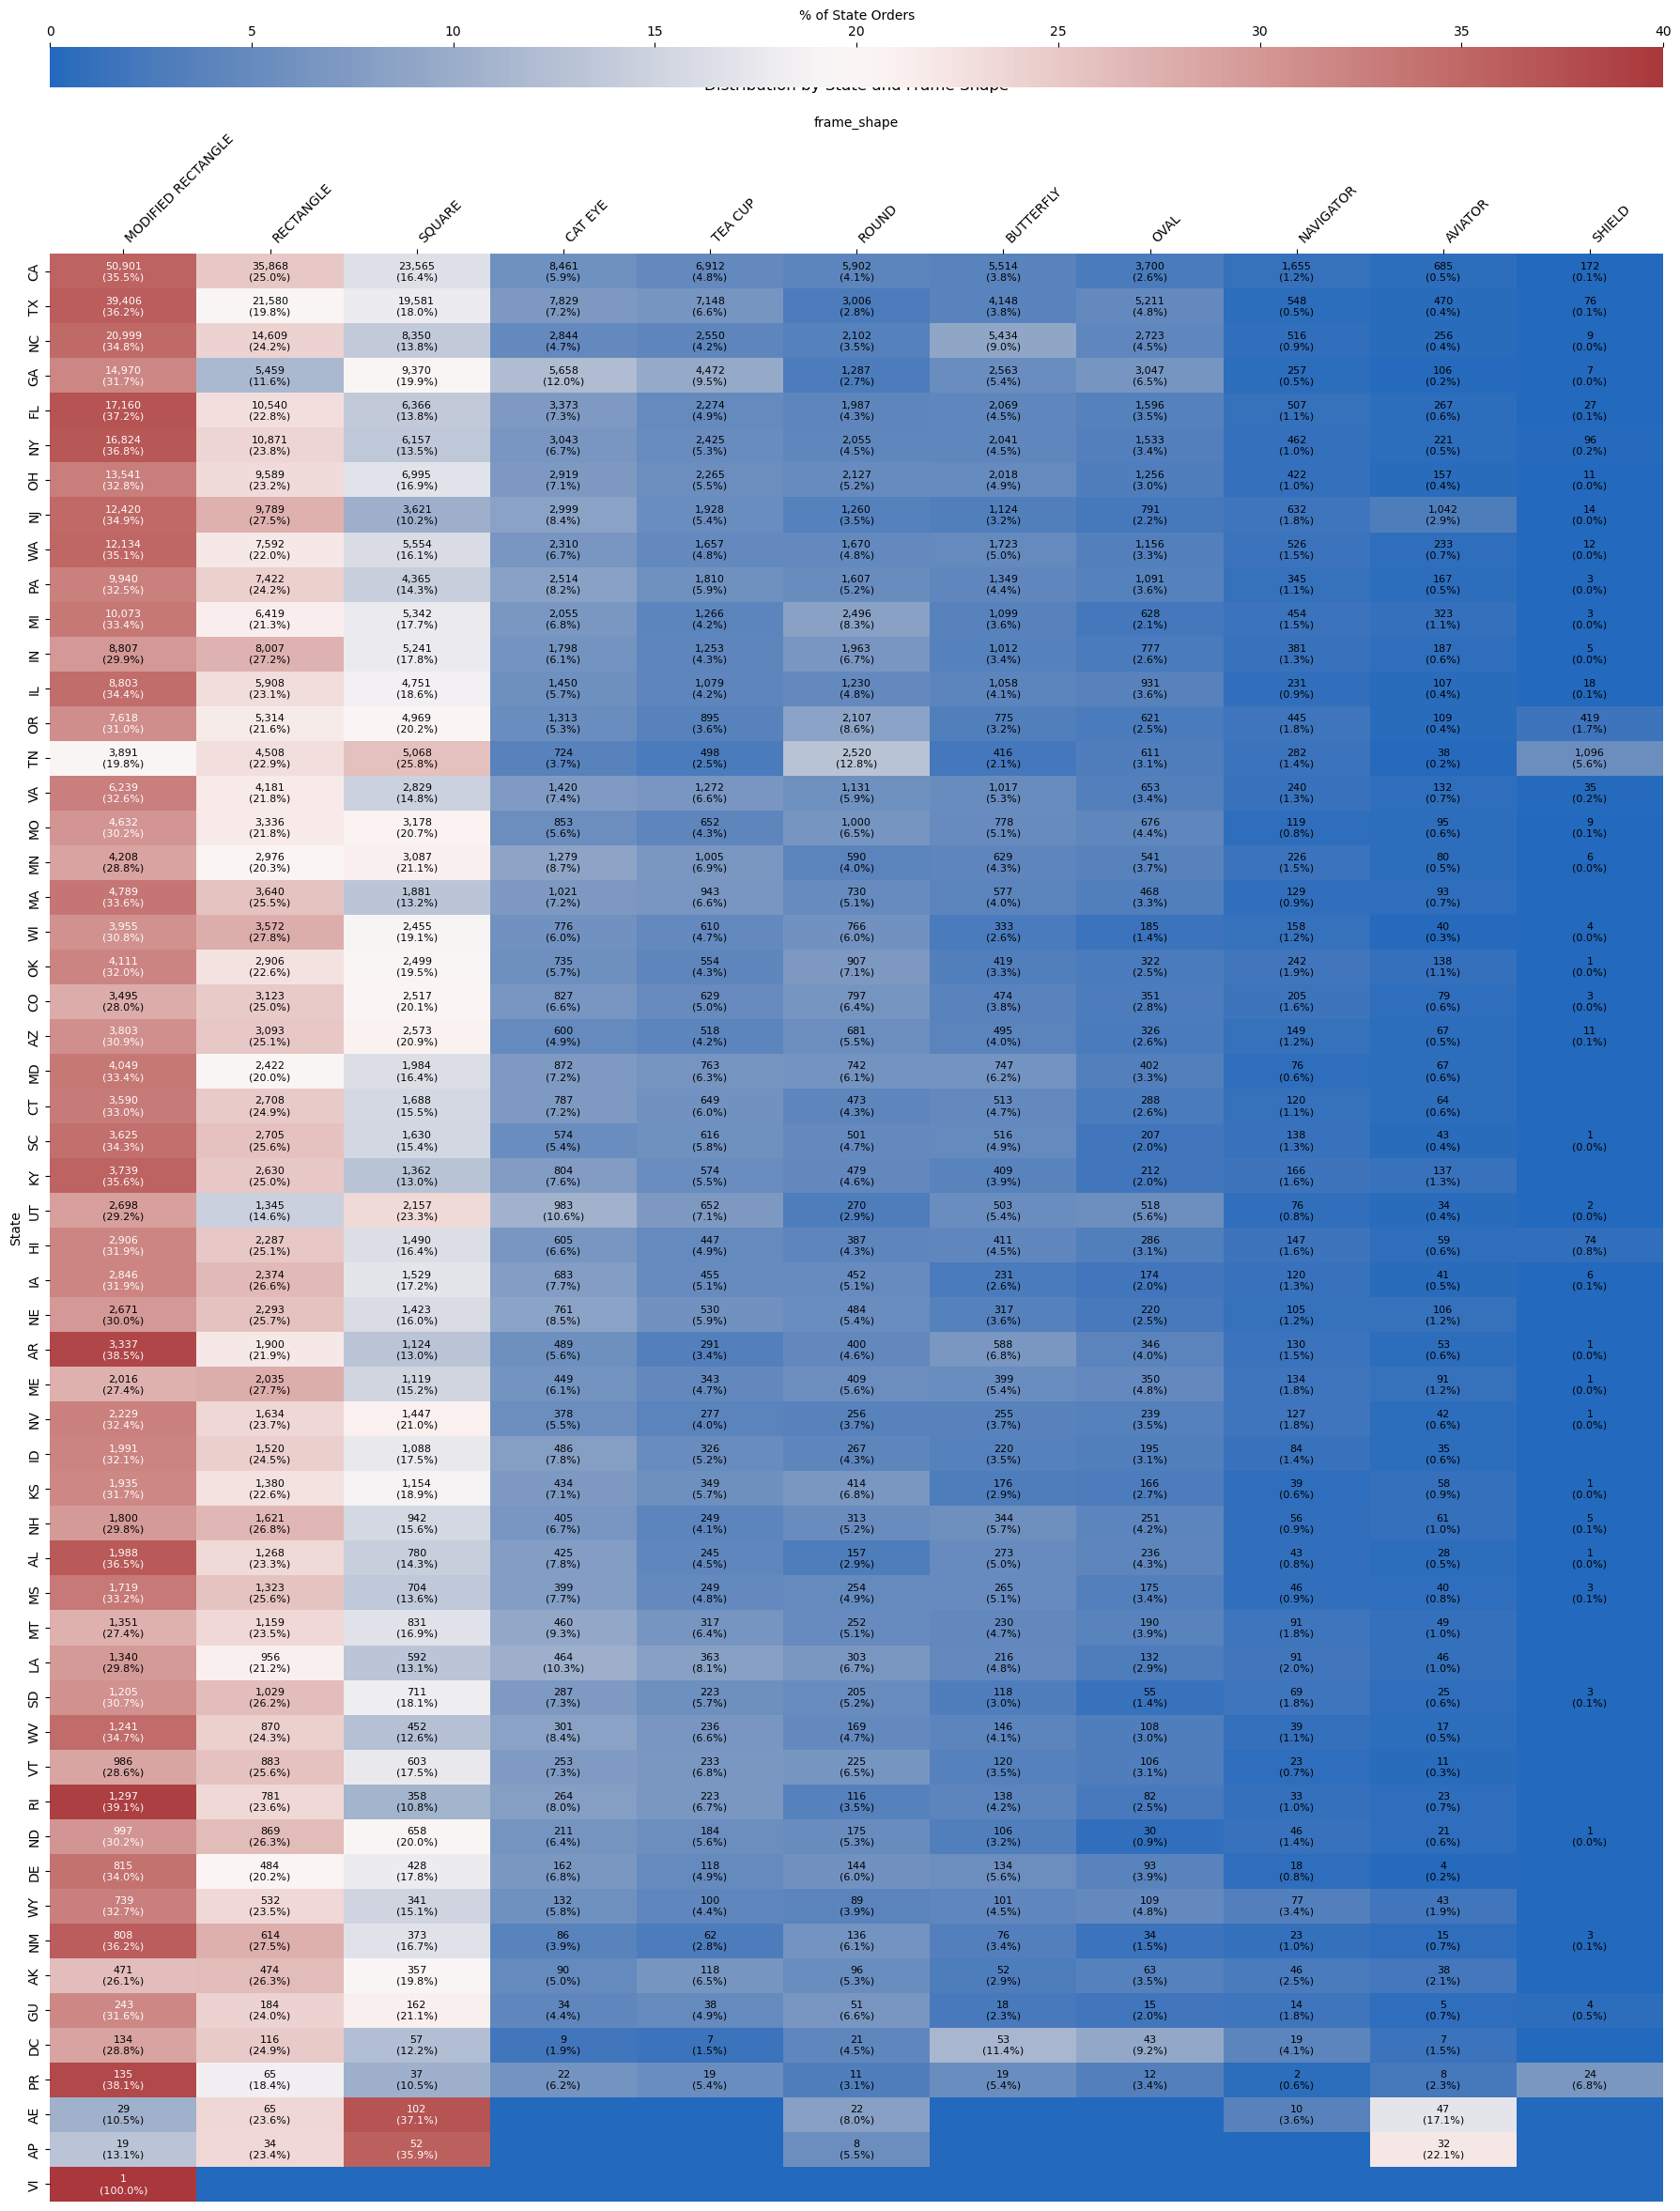

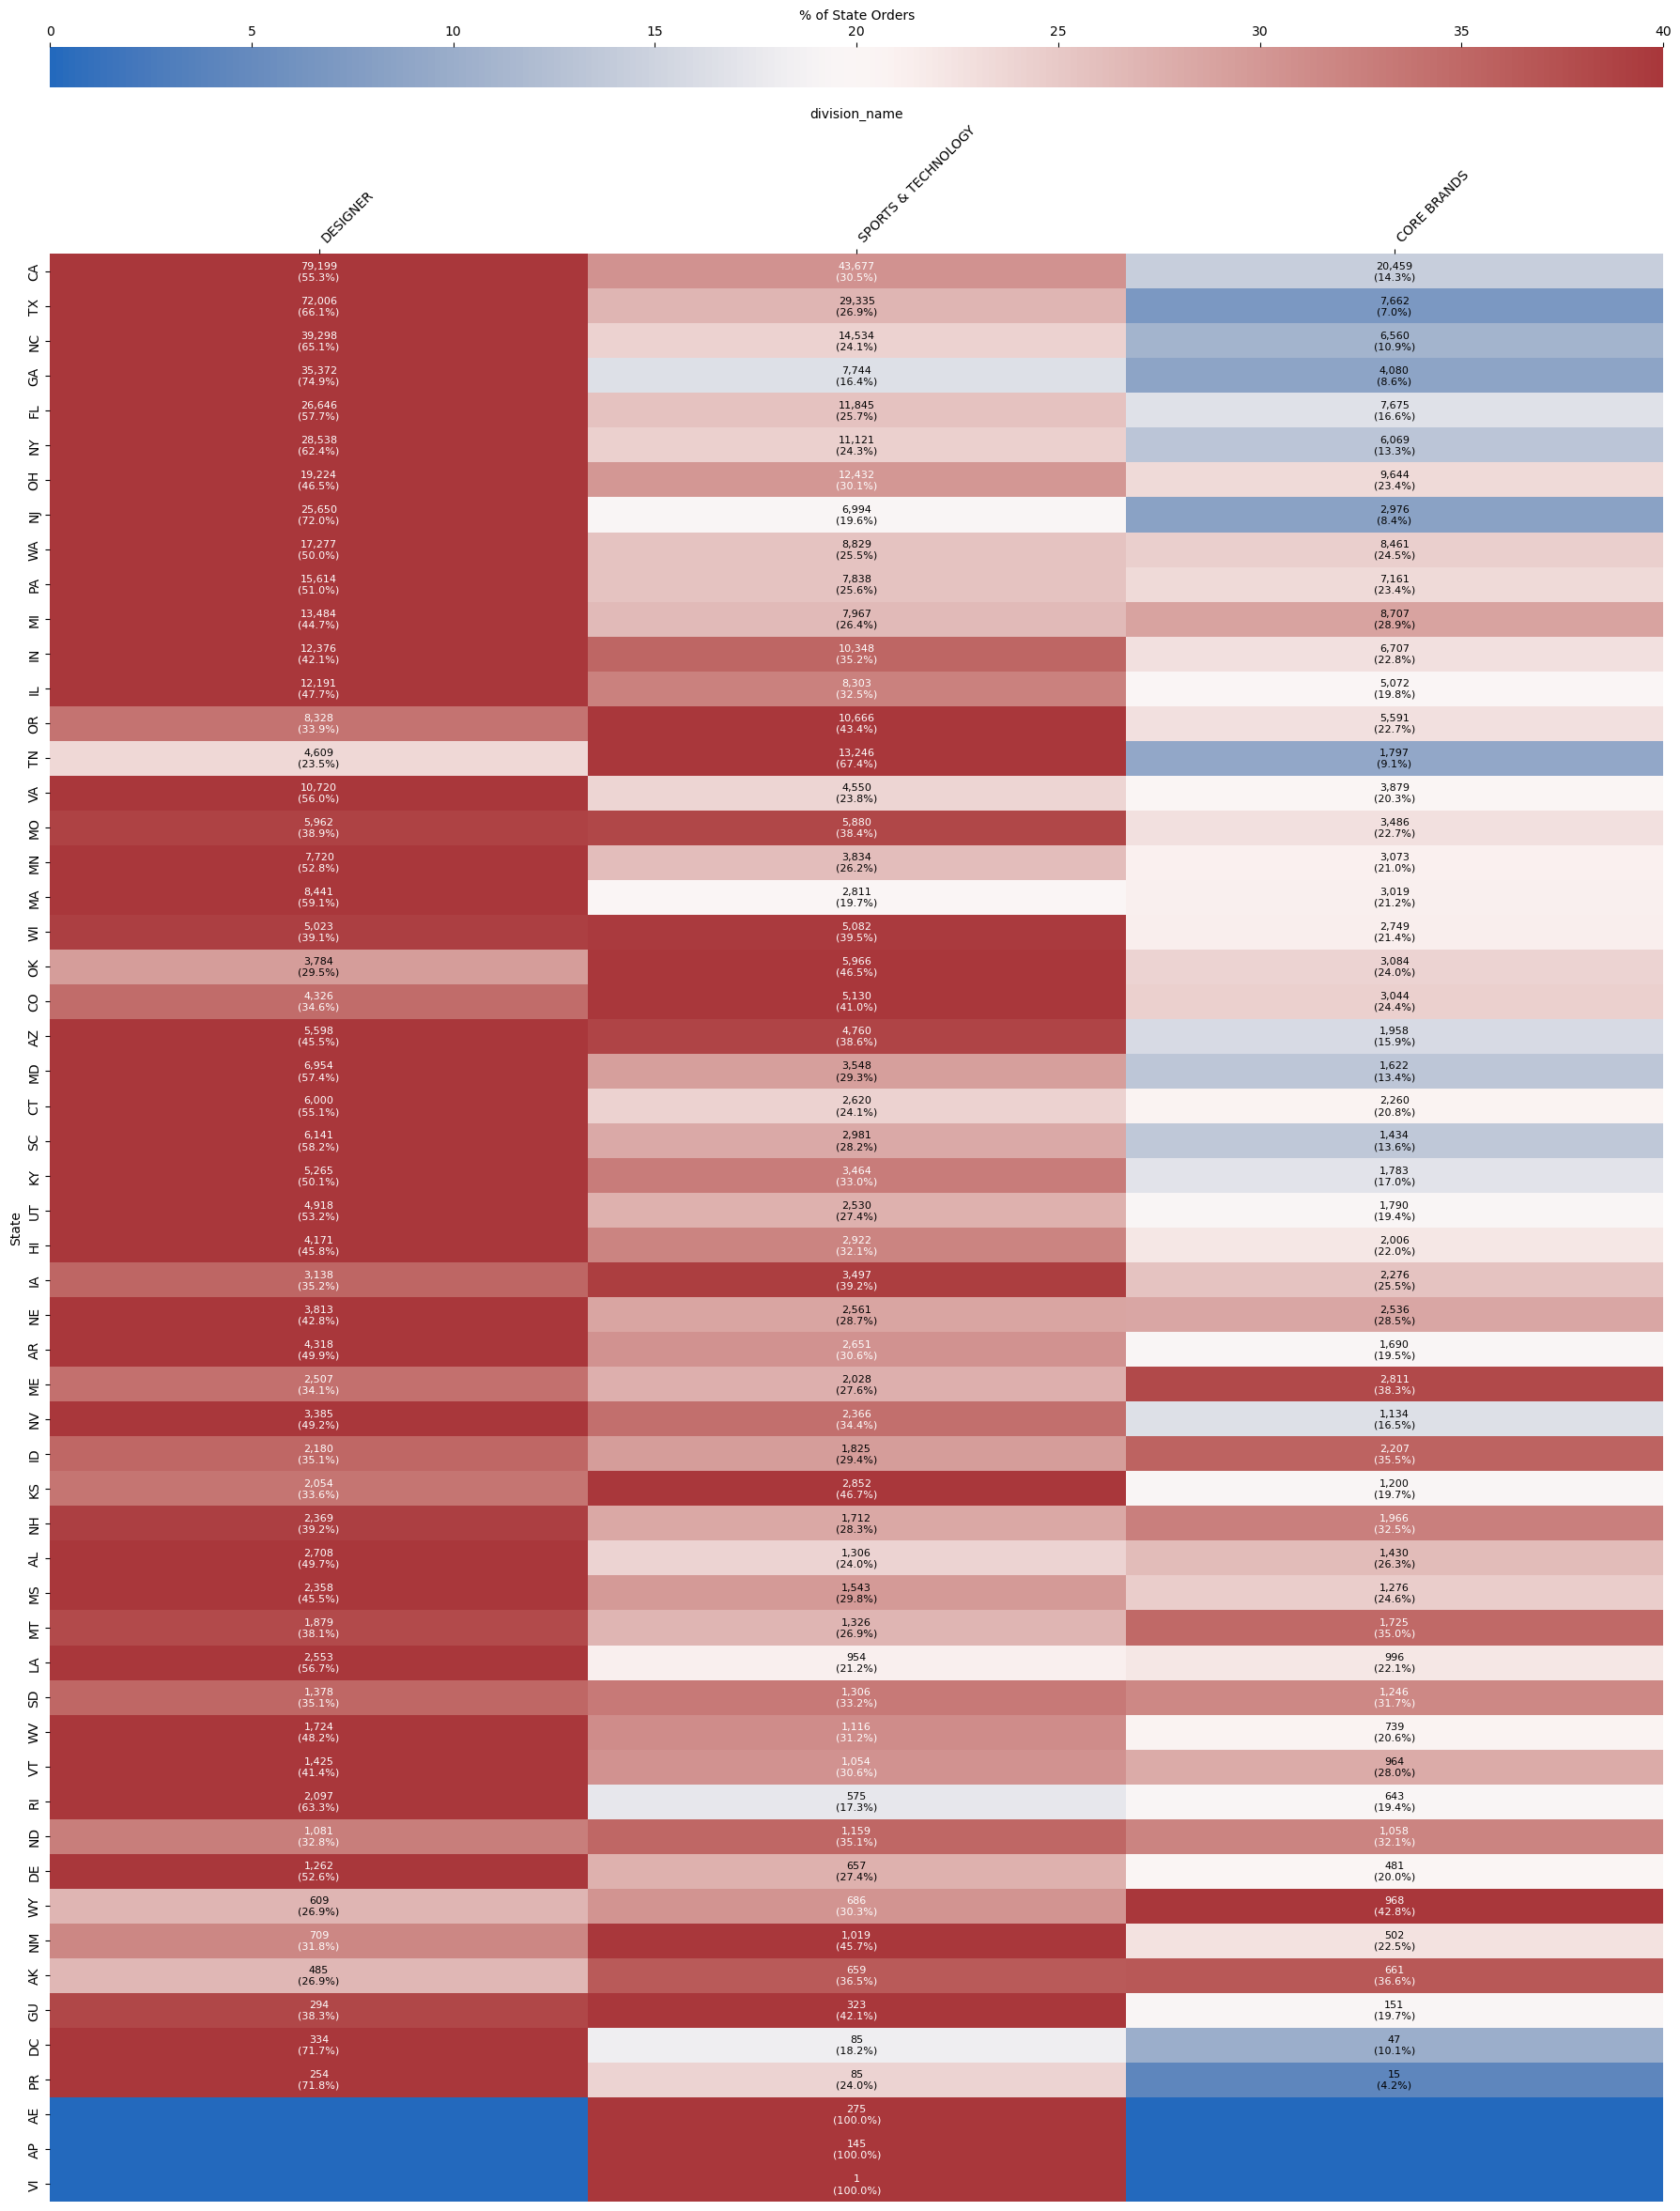

In [7]:
categories = ['brand_name', 'front_material_name', 'color_family', 'frame_shape', 'division_name']

for category in categories:
    create_state_category_heatmap(df, category)

## Analysis: Data Preparation and Clustering 

In [8]:
# Further data preparation
cdf = df.copy()
cdf['location'] = cdf[['city', 'city_district']].apply(lambda x: x['city'] + '_' + x['city_district'], axis=1)
cdf = cdf.drop(['gender_code', 'frame_shape_code'], axis=1)
cdf = cdf.drop(['size'], axis=1) # just a combination of other columns


# Convert hex colors to RGB
cdf[['R', 'G', 'B']] = cdf['hex_color'].apply(lambda x: pd.Series([
    int(x[1:3], 16),
    int(x[3:5], 16),
    int(x[5:7], 16)
]))
# Scale RGB values to 0-1 range
cdf[['R_scaled', 'G_scaled', 'B_scaled']] = cdf[['R', 'G', 'B']] / 255.0


# Remove order_qty = 0
cdf = cdf[cdf['order_qty'] != 0]

In [9]:
GROUP_LEVEL = 'state' # location or state

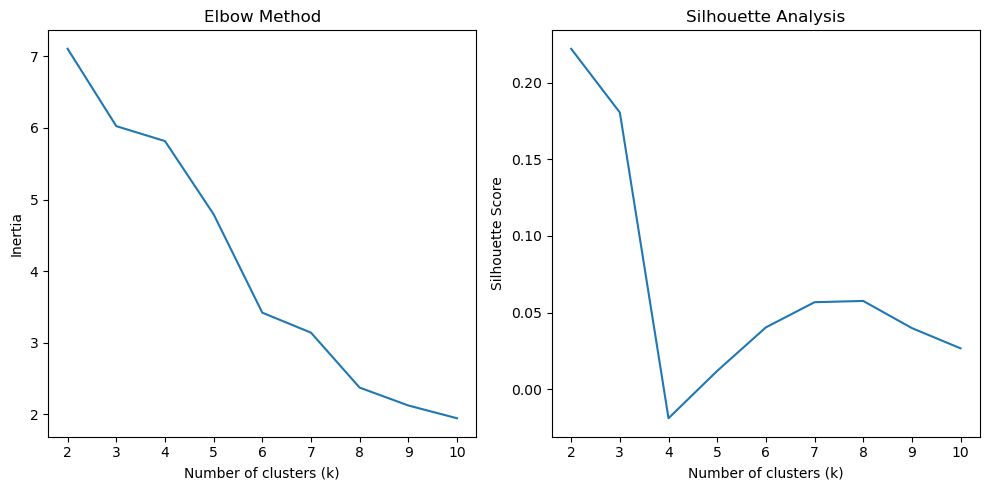

['color_family']


In [10]:
# Initialize
clusterer = PreferenceClustering(cdf)

results, centers, metrics = clusterer.perform_clustering(
    feature_cols=['color_family'],
    group_level=GROUP_LEVEL,
    n_clusters=4
)

# Plot elbow curve
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(metrics['k_values'], metrics['inertias'])
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')

plt.subplot(1, 2, 2)
plt.plot(metrics['k_values'], metrics['silhouette_scores'])
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')
plt.tight_layout()
plt.show()

# Get insights
print(clusterer.feature_cols)
compiled_clusters = results.copy()
color_insights = clusterer.get_cluster_insights(results, centers)

compiled_clusters.columns = ['Cluster_color']

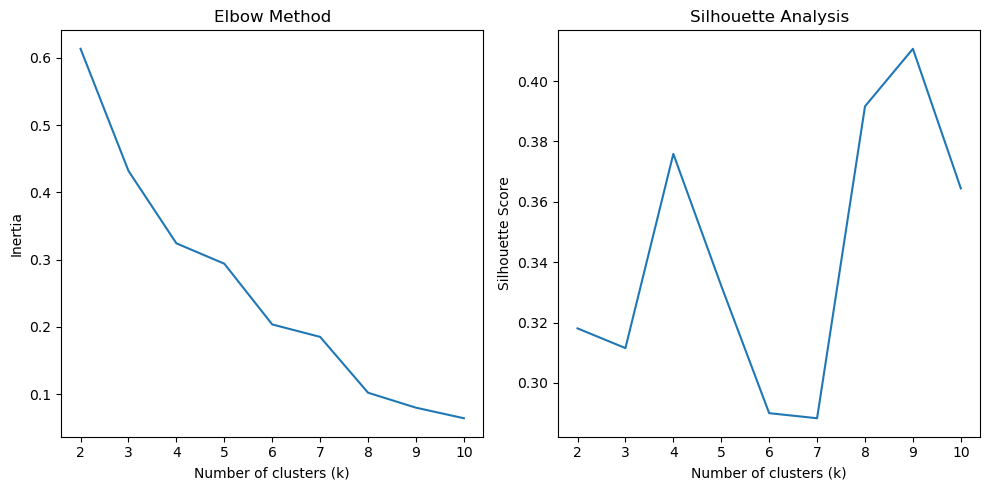

['division_name']


In [11]:
results, centers, metrics = clusterer.perform_clustering(
    feature_cols=['division_name'],
    group_level=GROUP_LEVEL,
    n_clusters=7
)

# Plot elbow curve
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(metrics['k_values'], metrics['inertias'])
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')

plt.subplot(1, 2, 2)
plt.plot(metrics['k_values'], metrics['silhouette_scores'])
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')
plt.tight_layout()
plt.show()

# Get insights
print(clusterer.feature_cols)
division_insights = clusterer.get_cluster_insights(results, centers)

results.columns = ['Cluster_division']
compiled_clusters = compiled_clusters.merge(results, on=GROUP_LEVEL)

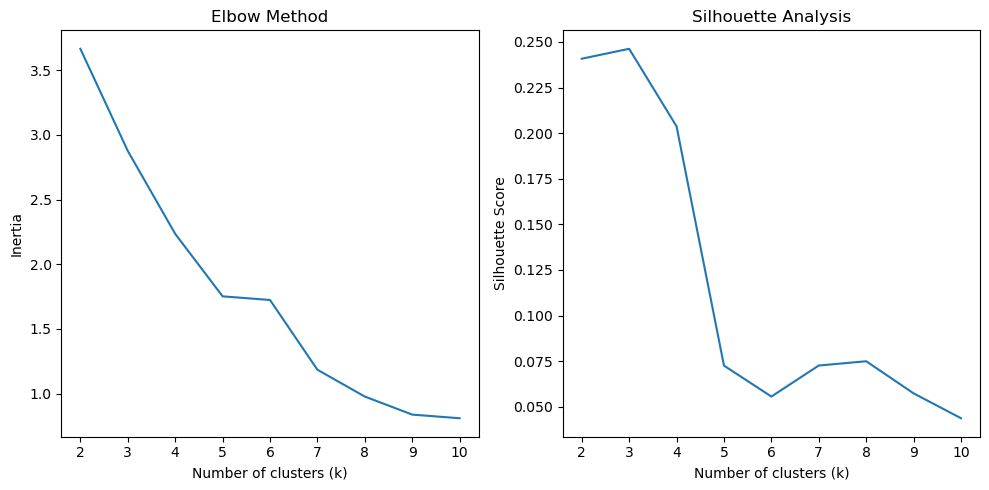

['frame_shape']


In [12]:
results, centers, metrics = clusterer.perform_clustering(
    feature_cols=['frame_shape'],
    group_level=GROUP_LEVEL,
    n_clusters=4
)

# Plot elbow curve
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(metrics['k_values'], metrics['inertias'])
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')

plt.subplot(1, 2, 2)
plt.plot(metrics['k_values'], metrics['silhouette_scores'])
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')
plt.tight_layout()
plt.show()

# Get insights
print(clusterer.feature_cols)
frame_shape_insights = clusterer.get_cluster_insights(results, centers)

results.columns = ['Cluster_frame_shape']
compiled_clusters = compiled_clusters.merge(results, on=GROUP_LEVEL)

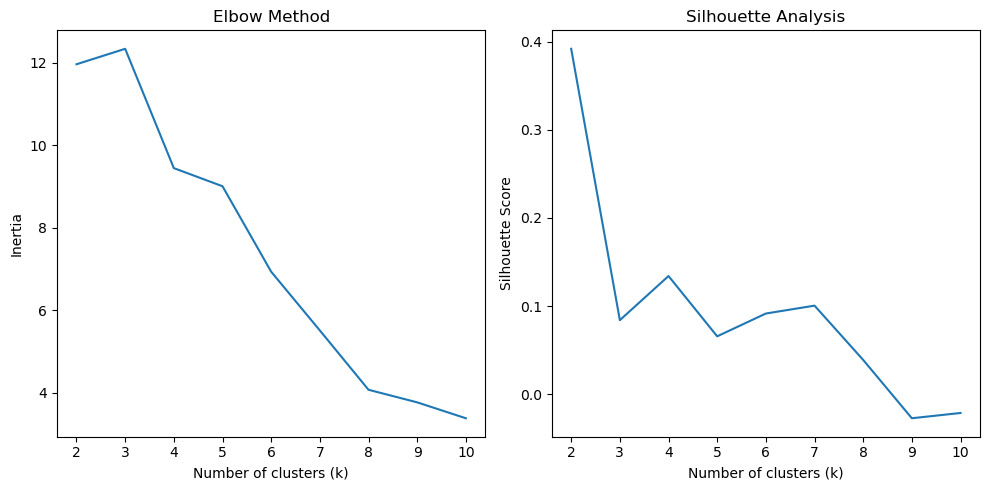

['brand_name']


In [13]:
results, centers, metrics = clusterer.perform_clustering(
    feature_cols=['brand_name'],
    group_level=GROUP_LEVEL,
    n_clusters=5
)

# Plot elbow curve
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(metrics['k_values'], metrics['inertias'])
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')

plt.subplot(1, 2, 2)
plt.plot(metrics['k_values'], metrics['silhouette_scores'])
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')
plt.tight_layout()
plt.show()

# Get insights
print(clusterer.feature_cols)
brand_insights = clusterer.get_cluster_insights(results, centers)

results.columns = ['Cluster_brand']
compiled_clusters = compiled_clusters.merge(results, on=GROUP_LEVEL)

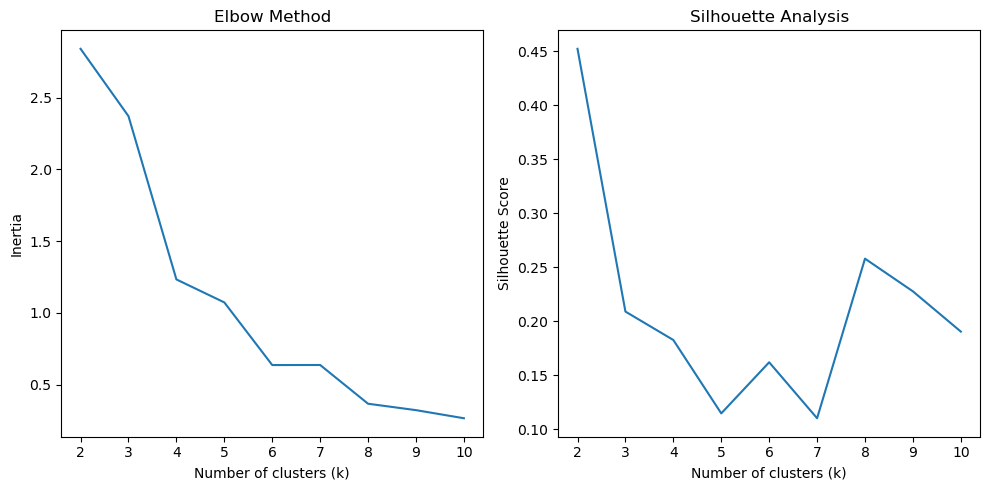

['gender']


In [14]:
results, centers, metrics = clusterer.perform_clustering(
    feature_cols=['gender'],
    group_level=GROUP_LEVEL,
    n_clusters=2
)

# Plot elbow curve
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(metrics['k_values'], metrics['inertias'])
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')

plt.subplot(1, 2, 2)
plt.plot(metrics['k_values'], metrics['silhouette_scores'])
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')
plt.tight_layout()
plt.show()

# Get insights
print(clusterer.feature_cols)
gender_insights = clusterer.get_cluster_insights(results, centers)

results.columns = ['Cluster_gender']
compiled_clusters = compiled_clusters.merge(results, on=GROUP_LEVEL)

In [15]:
from pprint import pprint

pprint(brand_insights)
pprint(color_insights)
pprint(gender_insights)
pprint(division_insights)
pprint(frame_shape_insights)

{'Cluster_0': {'regions': ['AE',
                           'AP',
                           'KS',
                           'MO',
                           'NH',
                           'NM',
                           'OK',
                           'OR',
                           'TN'],
               'size': 9,
               'top_features': {'brand1': 1.1380218501554575,
                                'brand15': 1.758941090408406,
                                'brand18': 0.6832212562800816,
                                'brand3': 0.2540136653325583,
                                'brand8': -0.027645377681603946}},
 'Cluster_1': {'regions': ['AK',
                           'AL',
                           'CO',
                           'CT',
                           'DE',
                           'GU',
                           'IA',
                           'ID',
                           'IN',
                           'KY',
                           'LA

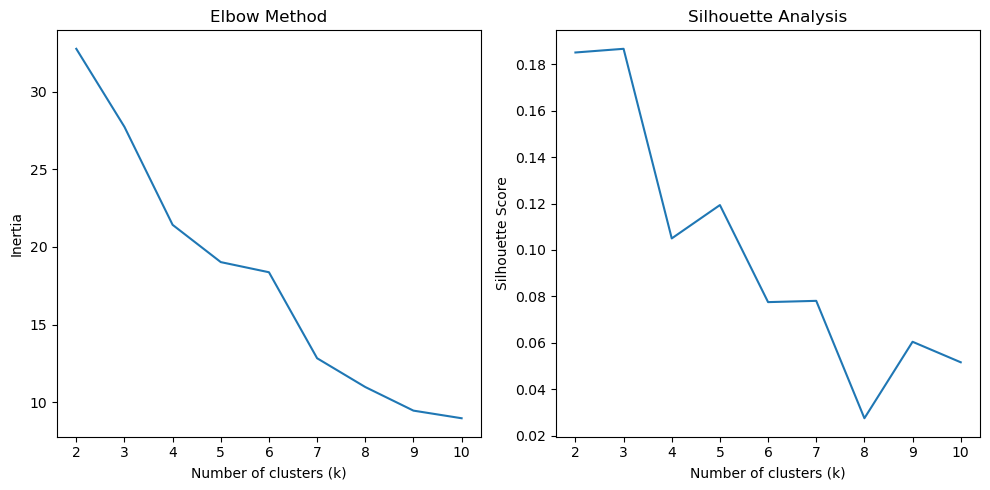

{'Cluster_0': {'regions': ['AE',
                           'AP',
                           'GU',
                           'IN',
                           'KS',
                           'MO',
                           'NM',
                           'OK',
                           'OR',
                           'TN',
                           'WI'],
               'size': 11,
               'top_features': {'CLEAR': 0.7497854778298709,
                                'GREY': 1.0423057396747875,
                                'ROUND': 1.5429757444761305,
                                'SHIELD': 0.8045934899204348,
                                'brand15': 1.3333956051676759}},
 'Cluster_1': {'regions': ['MN', 'UT'],
               'size': 2,
               'top_features': {'BROWN': 2.24172751095423,
                                'CAT EYE': 1.343974865124478,
                                'FEMALE': 1.3946655841018567,
                                'brand2': 1.5455524

In [16]:
results, centers, metrics = clusterer.perform_clustering(
    feature_cols=['color_family', 'frame_shape', 'division_name', 'brand_name', 'gender'],
    group_level='state',
    n_clusters=7
)

# Plot elbow curve
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(metrics['k_values'], metrics['inertias'])
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')

plt.subplot(1, 2, 2)
plt.plot(metrics['k_values'], metrics['silhouette_scores'])
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')
plt.tight_layout()
plt.show()

# Get insights
combined_insights = clusterer.get_cluster_insights(results, centers)
pprint(combined_insights)

## Make customer segment archetypes using Claude 
(or maybe we can try out other as well, using reasoning models may seem interesting?)

In [17]:
# from dspm_config import CLAUDE_API_KEY

# code from anthropic's API guide / documentation
import anthropic

client = anthropic.Anthropic(
    api_key=CLAUDE_API_KEY,
)

model = "claude-3-7-sonnet-latest"
# model = "claude-3-5-haiku-latest"

ModuleNotFoundError: No module named 'anthropic'

In [ ]:
system_prompt = """
You are the product manager for an eyewear frames seller in the US. You are experienced with data analysis. 
DATA COMPLETENESS, ACCURACY, AND COMMON SENSE is extremely important.
In these tasks, we will examine customer segmentation and clustering.
Our ultimate goal is to maximize revenue / sales of our products. 
Do not provide any "meh" and "buzzword"-y responses such as "these will help you Plan inventory based on cluster sizes". 
Do not use advanced jargons, make our analysis publicly accessible, especially to those in the industry.
"""

messages = [
    {
        "role": "user",
        "content": """ 
            I have created clusters of our customers, but they are still in the form of 1, 2, etc. It's not easily read. So I need you to create 'archetypes' based on each insight.
            These insight are simply the values of the centroids. We assume they are representative of the cluster. 
            For each cluster, create archetypes, e.g. Cluster 1 by color: "Prefers black colored frames". This makes it easy to infer. Make the names intuitive and fun.
            THIS IS REALLY IMPORTANT: << Provide your reasoning on why you made these archetypes, and include the relevant values from insights I gave >>.
            DO NOT SKIP ANY CLUSTERS!! 
            The product manager perspective in this task will be based on how you name them so it is easier for PMs to make decisions based on the data. Make it as descriptive too as much as possible, e.g. instead of "dual brand enthusiasts", we can say the 2 specific brand name.
            """
    },
    {
        "role": "user",
        "content": f"These are the dataframe columns: {compiled_clusters.columns}"
    },
    # { 
    #     "role": "user",
    #     "content": str(gender_insights) # the analysis on gender dont make sense here, its very biased?
    # },
    {
        "role": "user",
        "content": str(brand_insights)
    },
    {
        "role": "user",
        "content": str(division_insights)
    },
    {
        "role": "user",
        "content": str(frame_shape_insights)
    },
    {
        "role": "user",
        "content": str(color_insights)
    },
]

describing_clusters_response = client.messages.create(
    model=model,
    max_tokens=16384,
    temperature=0.01,
    system=system_prompt,
    messages=messages,
)



In [ ]:
print(describing_clusters_response.content[0].text)

# Customer Archetypes Based on Clustering Analysis

## Color Clusters

### Cluster 0: "The Earthy Elegance" (GA, MN, UT)
**Reasoning**: This cluster shows a strong preference for brown frames (3.41) with some interest in silver (0.84), while showing negative values for green, multicolor, and black.
- **Key Values**: BROWN: 3.41, SILVER: 0.84

### Cluster 1: "Vibrant Personality Seekers" (AL, DC, IN, MD, MO, NC, NH, NM, OK, OR, TN)
**Reasoning**: This group prefers bright, statement colors with orange (1.12) leading, followed by purple (0.68), multicolor (0.66), grey (0.57), and clear (0.56) frames.
- **Key Values**: ORANGE: 1.12, PURPLE: 0.68, MULTICOLOR: 0.66

### Cluster 2: "Luxury Metallics" (AE, AP)
**Reasoning**: This cluster strongly favors gold (4.39) and clear (4.02) frames with some black (1.89) and silver (0.94), suggesting a preference for premium, elegant looks.
- **Key Values**: GOLD: 4.39, CLEAR: 4.02, BLACK: 1.89

### Cluster 3: "Colorful Classics" (39 regions including 

The following were Claude's response:

In [ ]:
# ## Color Clusters

# ### Cluster 0: "The Earthy Elegance" (GA, MN, UT)
# **Reasoning**: This cluster shows a strong preference for brown frames (3.41) with some interest in silver (0.84), while showing negative values for green, multicolor, and black.
# - **Key Values**: BROWN: 3.41, SILVER: 0.84

# ### Cluster 1: "Vibrant Personality Seekers" (AL, DC, IN, MD, MO, NC, NH, NM, OK, OR, TN)
# **Reasoning**: This group prefers bright, statement colors with orange (1.12) leading, followed by purple (0.68), multicolor (0.66), grey (0.57), and clear (0.56) frames.
# - **Key Values**: ORANGE: 1.12, PURPLE: 0.68, MULTICOLOR: 0.66

# ### Cluster 2: "Luxury Metallics" (AE, AP)
# **Reasoning**: This cluster strongly favors gold (4.39) and clear (4.02) frames with some black (1.89) and silver (0.94), suggesting a preference for premium, elegant looks.
# - **Key Values**: GOLD: 4.39, CLEAR: 4.02, BLACK: 1.89

# ### Cluster 3: "Colorful Classics" (39 regions including AK, CA, FL, NY, TX)
# **Reasoning**: This widespread group prefers yellow (0.51), green (0.40), pink (0.39), blue (0.17), and tortoise (0.16) frames, showing a balanced interest in colorful yet traditional options.
# - **Key Values**: YELLOW: 0.51, GREEN: 0.40, PINK: 0.39

# ## Frame Shape Clusters

# ### Cluster 0: "Rectangle & Butterfly Enthusiasts" (48 regions - nationwide)
# **Reasoning**: This dominant cluster shows preference for rectangle (0.23) and butterfly (0.19) frames, with some interest in modified rectangle (0.10).
# - **Key Values**: RECTANGLE: 0.23, BUTTERFLY: 0.19, MODIFIED RECTANGLE: 0.10

# ### Cluster 1: "Curved Contour Lovers" (GA, MN, TX, UT)
# **Reasoning**: This group favors oval (1.38), tea cup (1.37), and cat eye (1.02) shapes, showing a preference for frames with curved, feminine contours.
# - **Key Values**: OVAL: 1.38, TEA CUP: 1.37, CAT EYE: 1.02

# ### Cluster 2: "Bold Geometric Trendsetters" (AE, AP)
# **Reasoning**: This cluster strongly prefers aviator (4.88), square (3.63), navigator (1.40), and round (1.09) frames, suggesting a taste for bold, geometric styles.
# - **Key Values**: AVIATOR: 4.88, SQUARE: 3.63, NAVIGATOR: 1.40, ROUND: 1.09

# ### Cluster 3: "Statement Shield Wearers" (TN)
# **Reasoning**: This unique cluster shows very strong preference for shield (4.53) and round (4.23) frames, with some interest in square (1.61).
# - **Key Values**: SHIELD: 4.53, ROUND: 4.23, SQUARE: 1.61

# ## Division Clusters

# ### Cluster 0: "Sports Tech Specialists" (TN)
# **Reasoning**: This single-region cluster strongly favors sports & technology frames (1.84) while showing negative interest in core brands (-1.21) and designer frames (-1.32).
# - **Key Values**: SPORTS & TECHNOLOGY: 1.84

# ### Cluster 1: "Performance Eyewear Enthusiasts" (AE, AP)
# **Reasoning**: This cluster shows extremely high preference for sports & technology frames (3.67) with strong negative values for core brands (-2.19) and designer frames (-2.77).
# - **Key Values**: SPORTS & TECHNOLOGY: 3.67

# ### Cluster 2: "Balanced Sports & Core Shoppers" (AZ, CO, GU, IA, IN, KS, MO, NM, OK, OR, WI)
# **Reasoning**: This group shows moderate interest in sports & technology (0.32) and core brands (0.20) with less interest in designer frames (-0.46).
# - **Key Values**: SPORTS & TECHNOLOGY: 0.32, CORE BRANDS: 0.20

# ### Cluster 3: "Designer Frame Aficionados" (CA, FL, KY, MD, NV, NY, RI, SC)
# **Reasoning**: This cluster prefers designer frames (0.73) while showing less interest in sports & technology (-0.34) and core brands (-0.62).
# - **Key Values**: DESIGNER: 0.73

# ### Cluster 4: "Core Brand Loyalists" (AK, ID, ME, MI, MT, ND, NE, NH, SD, VT, WY)
# **Reasoning**: This group strongly prefers core brands (1.22) with less interest in designer (-0.32) and sports & technology (-0.35) frames.
# - **Key Values**: CORE BRANDS: 1.22

# ### Cluster 5: "Luxury Designer Devotees" (DC, GA, NC, NJ, PR, TX)
# **Reasoning**: This cluster shows very strong preference for designer frames (1.44) with negative interest in sports & technology (-0.64) and core brands (-1.29).
# - **Key Values**: DESIGNER: 1.44

# ### Cluster 6: "Balanced Designer & Core Shoppers" (16 regions including AL, CT, IL, MA, OH, WA)
# **Reasoning**: This group shows moderate interest in designer frames (0.35) and core brands (0.19) with less interest in sports & technology (-0.42).
# - **Key Values**: DESIGNER: 0.35, CORE BRANDS: 0.19

# ## Brand Clusters

# ### Cluster 0: "Brand 10 & 11 Enthusiasts" (48 regions - nationwide)
# **Reasoning**: This dominant cluster shows preference for brand10 (0.42) and brand11 (0.42), with some interest in brand2 (0.25).
# - **Key Values**: brand10: 0.42, brand11: 0.42, brand2: 0.25

# ### Cluster 1: "Brand 7 & 13 Devotees" (DC, NJ, PR)
# **Reasoning**: This cluster strongly favors brand7 (4.30) and brand13 (2.52) with minimal interest in other brands.
# - **Key Values**: brand7: 4.30, brand13: 2.52

# ### Cluster 2: "Brand 19 Specialists" (MI)
# **Reasoning**: This single-region cluster shows extremely high preference for brand19 (7.03) with some interest in brand14 (1.07) and brand20 (0.88).
# - **Key Values**: brand19: 7.03, brand14: 1.07, brand20: 0.88

# ### Cluster 3: "Brand 5 & 2 Loyalists" (GA, UT)
# **Reasoning**: This cluster strongly prefers brand5 (5.17) and brand2 (2.91) with minimal interest in other brands.
# - **Key Values**: brand5: 5.17, brand2: 2.91

# ### Cluster 4: "Brand 9 & 10 Fans" (TX)
# **Reasoning**: This Texas-specific cluster shows very strong preference for brand9 (7.32) and brand10 (2.19), with some interest in brand11 (0.99) and brand5 (0.90).
# - **Key Values**: brand9: 7.32, brand10: 2.19, brand11: 0.99

# These archetypes provide intuitive, descriptive labels that make it easier for product managers to understand customer preferences and make data-driven decisions about inventory, marketing, and product development.

In [ ]:
messages = [{
        "role": "assistant",
        "content": describing_clusters_response.content[0].text
    },
    {
        "role": "user",
        "content": """ 
            Based on the below data, provide code (dictionary only) in Python to replace the clusters.
            Enclose the dictionary in symbol <dict> so I can parse it easily later.
            Again: PROVIDE MAPPING FOR EVERY SINGLE CLUSTERS! DO NOT SKIP ANYTHING. JUST PROVIDE THE DICTIONARY CONTENT WITHOUT DEFINITION 'cluster_mapping = {}'
            Double check that every cluster provided earlier IS INCLUDED in the mapping. 
            """
    },
    {
        "role": "user",
        "content": str(describing_clusters_response.content[0].text)
    },
    {
        "role": "user",
        "content": f"These are the final dataframe columns, use it for the mapping: {compiled_clusters.columns}"
    },
]

python_mapping_response = client.messages.create(
    model=model,
    max_tokens=8192,
    temperature=0.01,
    system=system_prompt,
    messages=messages,
)

In [ ]:
print(python_mapping_response.content[0].text)

<dict>
{
    'Cluster_color': {
        0: 'The Earthy Elegance',
        1: 'Vibrant Personality Seekers',
        2: 'Luxury Metallics',
        3: 'Colorful Classics'
    },
    'Cluster_frame_shape': {
        0: 'Rectangle & Butterfly Enthusiasts',
        1: 'Curved Contour Lovers',
        2: 'Bold Geometric Trendsetters',
        3: 'Statement Shield Wearers'
    },
    'Cluster_division': {
        0: 'Sports Tech Specialists',
        1: 'Performance Eyewear Enthusiasts',
        2: 'Balanced Sports & Core Shoppers',
        3: 'Designer Frame Aficionados',
        4: 'Core Brand Loyalists',
        5: 'Luxury Designer Devotees',
        6: 'Balanced Designer & Core Shoppers'
    },
    'Cluster_brand': {
        0: 'Brand 10 & 11 Enthusiasts',
        1: 'Brand 7 & 13 Devotees',
        2: 'Brand 19 Specialists',
        3: 'Brand 5 & 2 Loyalists',
        4: 'Brand 9 & 10 Fans'
    }
}
</dict>


The following were Claude's response:

In [ ]:
# <dict>

# {
#     'Cluster_color': {
#         0: 'The Earthy Elegance',
#         1: 'Vibrant Personality Seekers',
#         2: 'Luxury Metallics',
#         3: 'Colorful Classics'
#     },
#     'Cluster_frame_shape': {
#         0: 'Rectangle & Butterfly Enthusiasts',
#         1: 'Curved Contour Lovers',
#         2: 'Bold Geometric Trendsetters',
#         3: 'Statement Shield Wearers'
#     },
#     'Cluster_division': {
#         0: 'Sports Tech Specialists',
#         1: 'Performance Eyewear Enthusiasts',
#         2: 'Balanced Sports & Core Shoppers',
#         3: 'Designer Frame Aficionados',
#         4: 'Core Brand Loyalists',
#         5: 'Luxury Designer Devotees',
#         6: 'Balanced Designer & Core Shoppers'
#     },
#     'Cluster_brand': {
#         0: 'Brand 10 & 11 Enthusiasts',
#         1: 'Brand 7 & 13 Devotees',
#         2: 'Brand 19 Specialists',
#         3: 'Brand 5 & 2 Loyalists',
#         4: 'Brand 9 & 10 Fans'
#     }
# }

# </dict>

In [ ]:
cluster_mapping = ast.literal_eval(python_mapping_response.content[0].text.split("<dict>")[1].split("</dict>")[0])

cluster_mapping

{'Cluster_color': {0: 'The Earth Tone Enthusiasts',
  1: 'The Bold Expressionists',
  2: 'The Luxury Metallics',
  3: 'The Colorful Conservatives'},
 'Cluster_frame_shape': {0: 'The Classic Conformists',
  1: 'The Retro Revivalists',
  2: 'The Top Gun Trendsetters',
  3: 'The Fashion Forward'},
 'Cluster_brand': {0: 'The Mainstream Loyalists',
  1: 'The Niche Brand Devotees',
  2: 'The Exclusive Connoisseur',
  3: 'The Dual Brand Enthusiasts',
  4: 'The Brand9 Aficionado'},
 'Cluster_division': {0: 'The Sports Tech Specialist',
  1: 'The Ultimate Sports Enthusiasts',
  2: 'The Balanced Sports Fans',
  3: 'The Fashion Forward',
  4: 'The Core Brand Loyalists',
  5: 'The Luxury Design Devotees',
  6: 'The Balanced Fashion Seekers'}}

In [18]:
archetyped_clusters = compiled_clusters.copy().drop(['Cluster_gender'], axis=1)
# archetyped_clusters = compiled_clusters.copy()

for column in archetyped_clusters:
    archetyped_clusters[column] = compiled_clusters[column].map(cluster_mapping[column])
    
archetyped_clusters

NameError: name 'cluster_mapping' is not defined

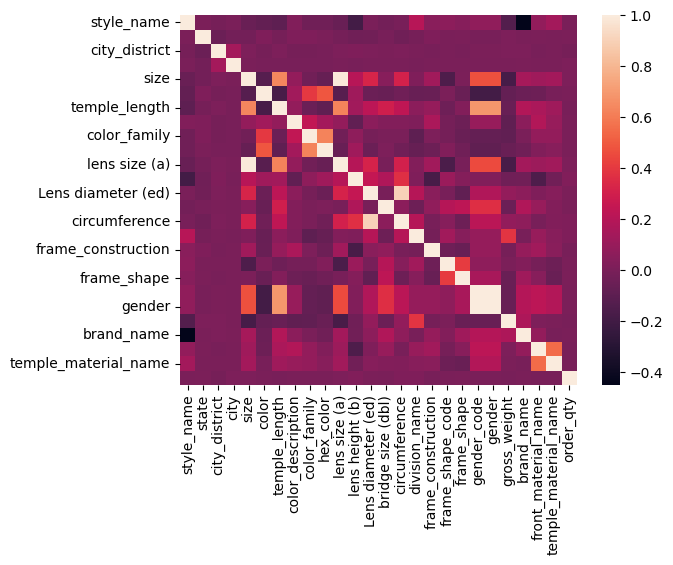

In [21]:
# Identifying columns of numerical variables
# num_columns = data.select_dtypes(include=['float64', 'int64'])
# corr_matrix = num_columns.corr()
# Encode categorical variables into numbers
encoded_data = df.apply(LabelEncoder().fit_transform)

# Compute correlation matrix
corr_matrix = encoded_data.corr()

# Create the heatmap
sns.heatmap(corr_matrix)
plt.show()

In [24]:
# Checking the pairs of gender and gender_code
unique_pairs_gender = df.groupby(['gender', 'gender_code']).size().reset_index(name='count')
print(unique_pairs_gender)

   gender gender_code   count
0     BOY           B   27131
1   CHILD           C   20394
2  FEMALE           F  263709
3    GIRL           G   12449
4    MALE           M  278303
5  UNISEX           U   45628


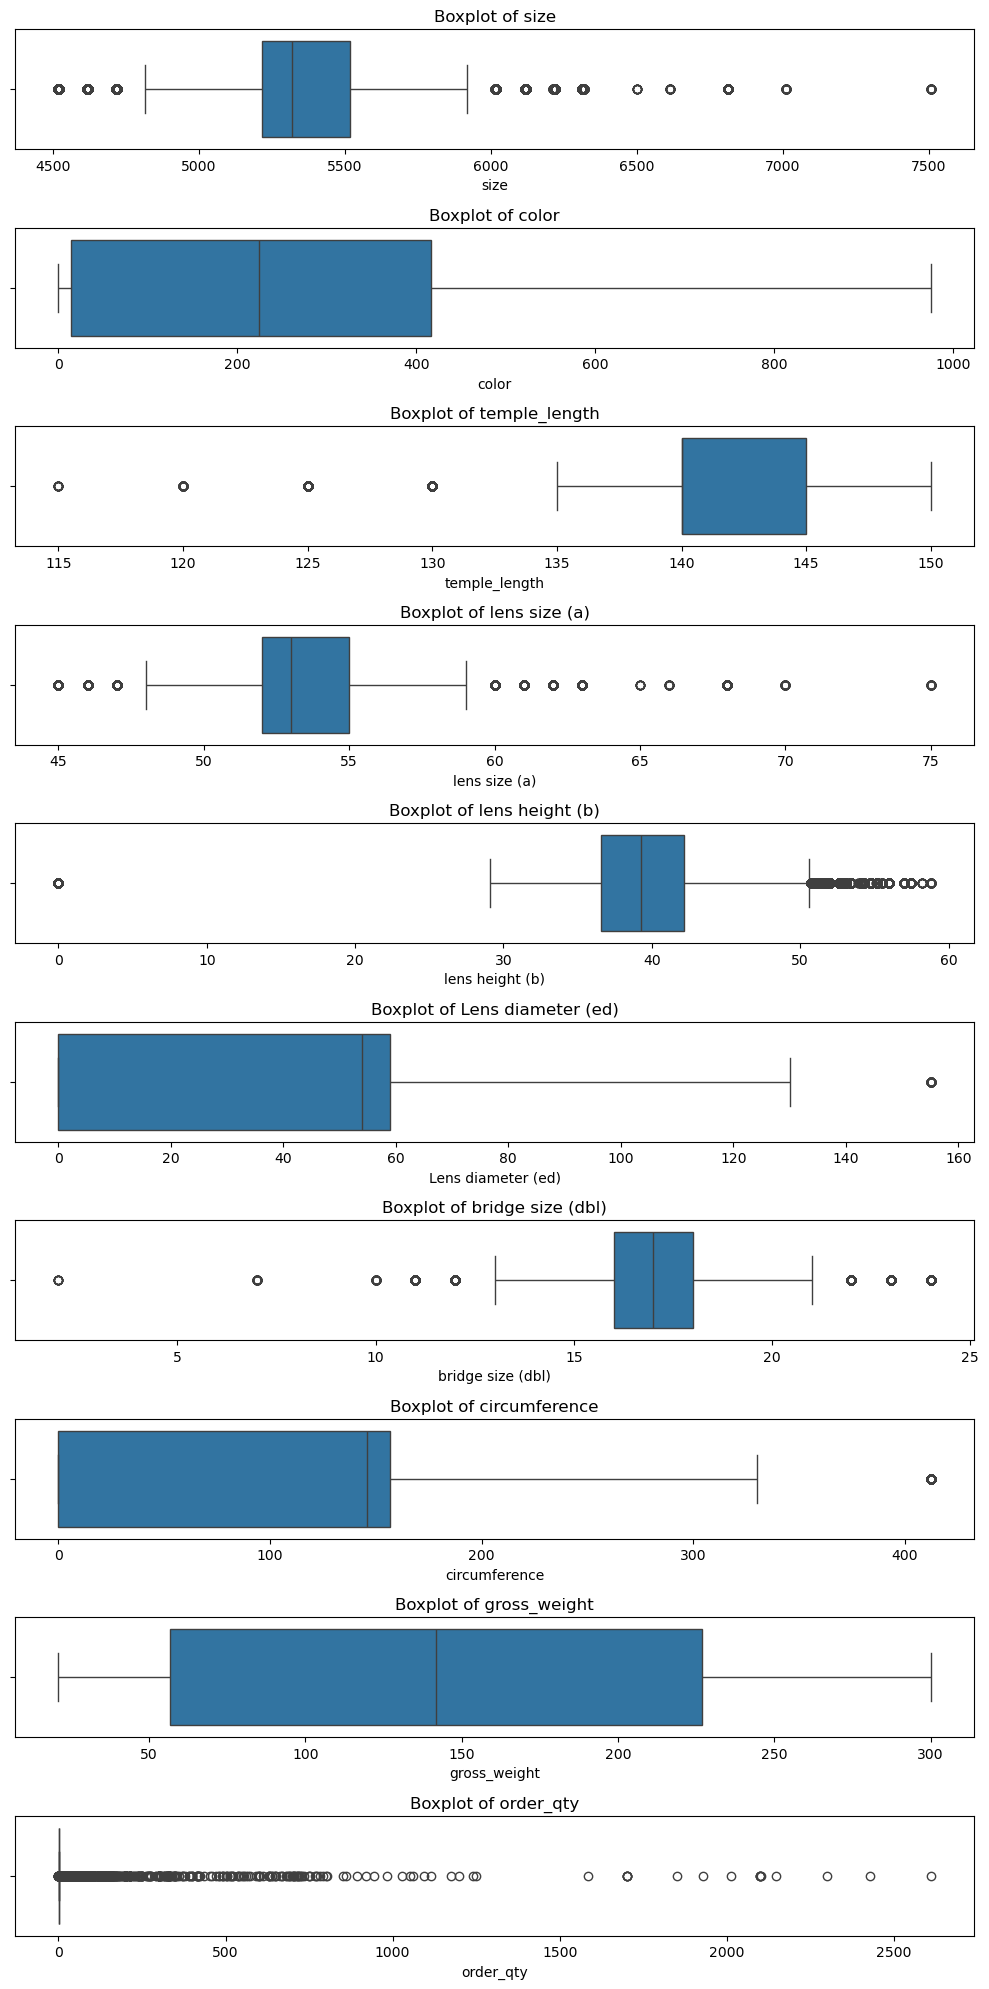

In [26]:
# Identifying columns of numerical variables
num_columns = df.select_dtypes(include=['float64', 'int64'])

# Create boxplots for each numerical column
plt.figure(figsize=(10, len(num_columns.columns) * 2))
for i, col in enumerate(num_columns.columns):
    plt.subplot(len(num_columns.columns), 1, i + 1)
    sns.boxplot(x=num_columns[col])
    plt.title(f"Boxplot of {col}")

plt.tight_layout()
plt.show()


Gender Distribution (%):
MALE: 42.97%
FEMALE: 40.72%
UNISEX: 7.05%
BOY: 4.19%
CHILD: 3.15%
GIRL: 1.92%


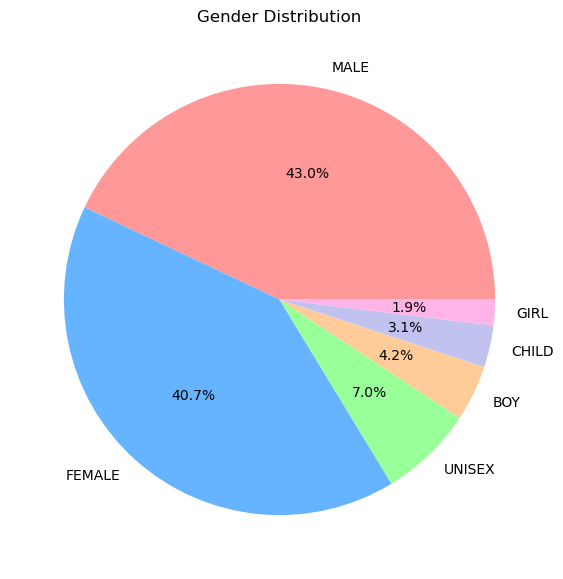

In [28]:
# Gender Distribution
gender_counts = df["gender"].value_counts()
total_count = gender_counts.sum()

# Calculating the percentage
gender_percentages = (gender_counts / total_count) * 100

# Print the percentages
print("Gender Distribution (%):")
for gender, percent in gender_percentages.items():
    print(f"{gender}: {percent:.2f}%")

# Visualization - pie chart
plt.figure(figsize=(7, 7))
plt.pie(gender_counts, labels=gender_counts.index, autopct="%1.1f%%", colors=["#ff9999","#66b3ff","#99ff99","#ffcc99","#c2c2f0","#ffb3e6"])
plt.title("Gender Distribution")
plt.show()

/var/folders/_n/1n_wsk3j6130g4g9lvjnxb200000gn/T/ipykernel_62155/3700434200.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="gender", order=df["gender"].value_counts().index, palette="Set2")


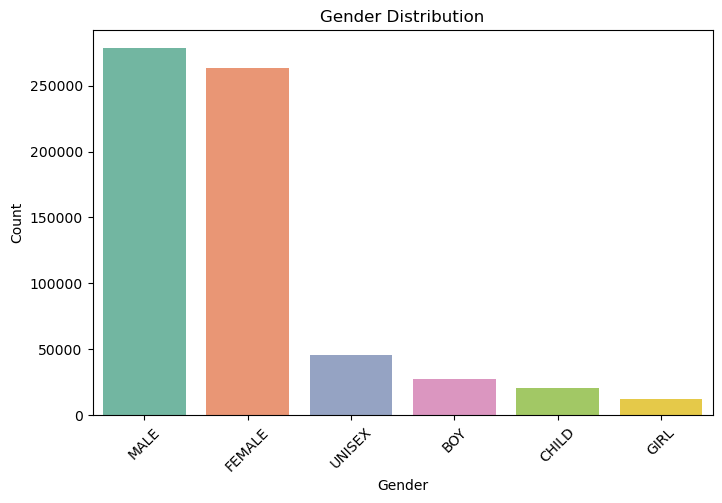

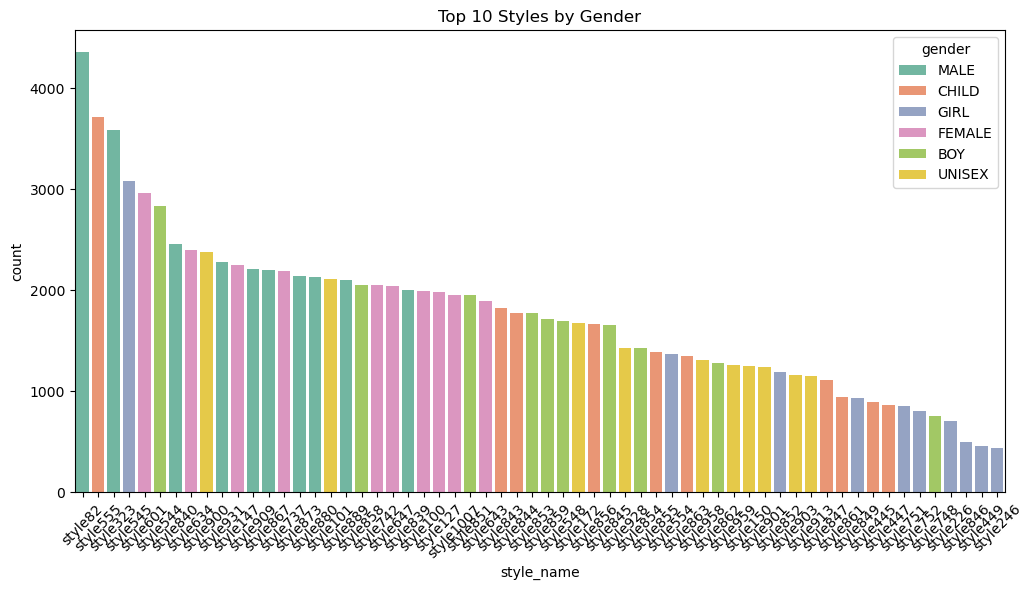

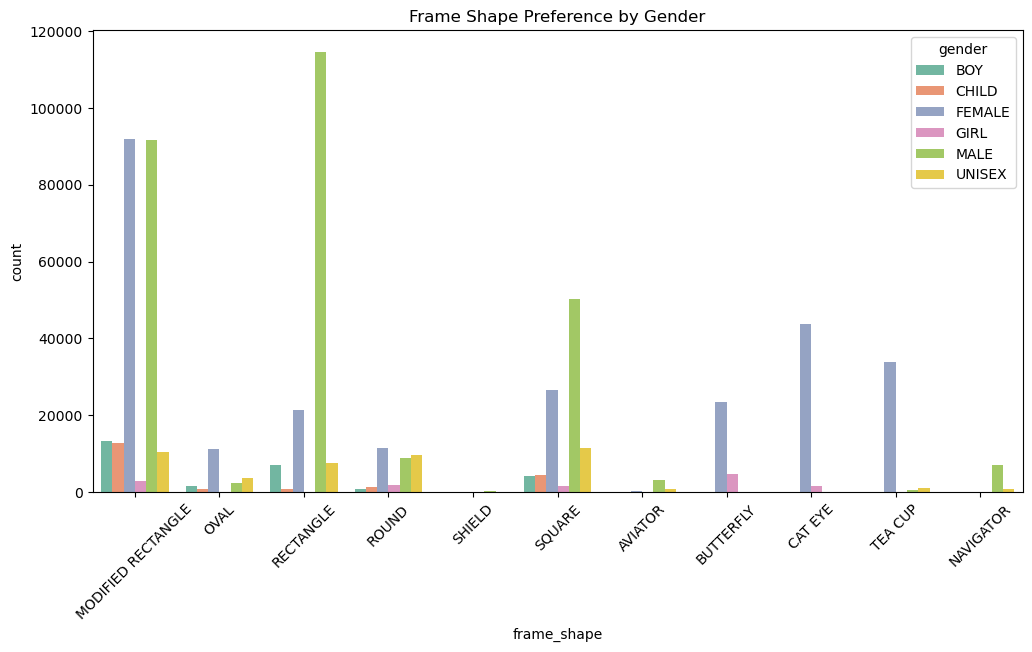

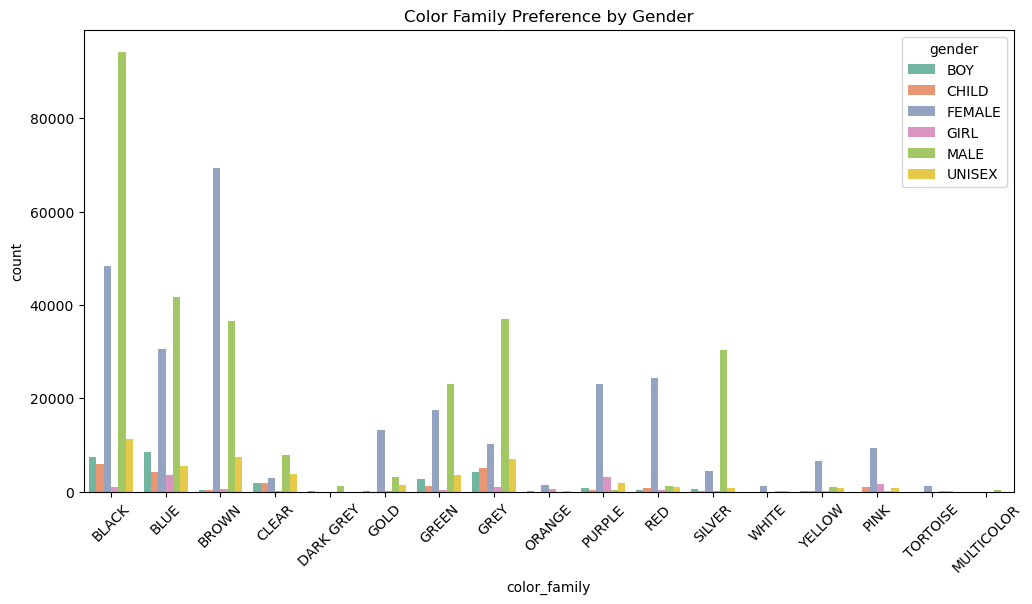

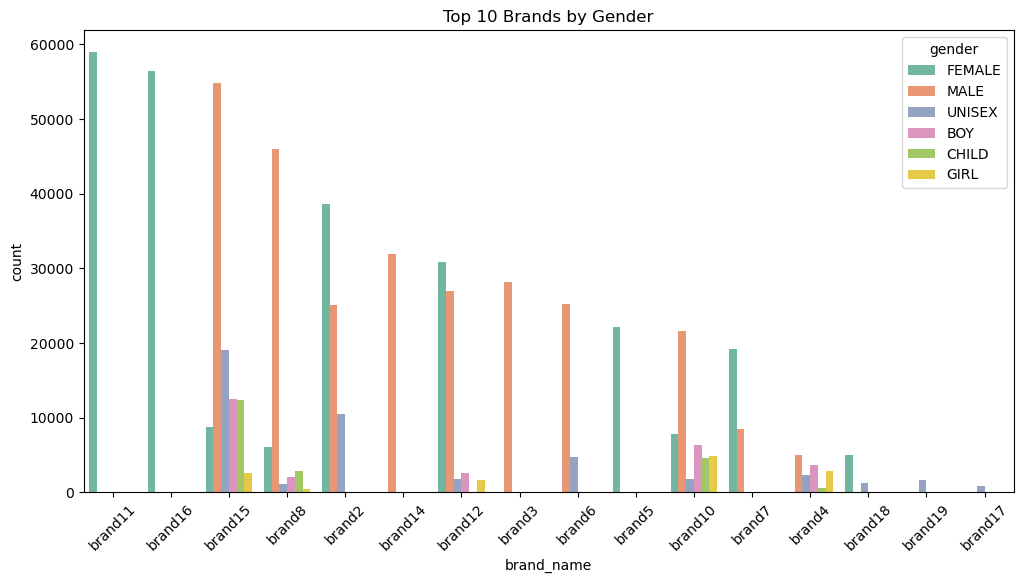

In [30]:
### 1. 성별 분포 시각화 ###
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x="gender", order=df["gender"].value_counts().index, palette="Set2")
plt.title("Gender Distribution")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

# 성별 리스트
genders = ["FEMALE", "MALE", "UNISEX", "BOY", "CHILD", "GIRL"]
data1 = df[df["gender"].isin(genders)]

### 2. 스타일 선호도 분석 ###
style_counts = df.groupby(["gender", "style_name"]).size().reset_index(name="count")
top_styles = style_counts.sort_values("count", ascending=False).groupby("gender").head(10)

plt.figure(figsize=(12, 6))
sns.barplot(data=top_styles, x="style_name", y="count", hue="gender", palette="Set2")
plt.xticks(rotation=45)
plt.title("Top 10 Styles by Gender")
plt.show()

### 3. 프레임 모양 선호도 ###
frame_counts = df.groupby(["gender", "frame_shape"]).size().reset_index(name="count")

plt.figure(figsize=(12, 6))
sns.barplot(data=frame_counts, x="frame_shape", y="count", hue="gender", palette="Set2")
plt.xticks(rotation=45)
plt.title("Frame Shape Preference by Gender")
plt.show()

### 4. 색상 선호도 분석 ###
color_counts = df.groupby(["gender", "color_family"]).size().reset_index(name="count")

plt.figure(figsize=(12, 6))
sns.barplot(data=color_counts, x="color_family", y="count", hue="gender", palette="Set2")
plt.xticks(rotation=45)
plt.title("Color Family Preference by Gender")
plt.show()

### 5. 브랜드 선호도 분석 ###
brand_counts = df.groupby(["gender", "brand_name"]).size().reset_index(name="count")
top_brands = brand_counts.sort_values("count", ascending=False).groupby("gender").head(10)

plt.figure(figsize=(12, 6))
sns.barplot(data=top_brands, x="brand_name", y="count", hue="gender", palette="Set2")
plt.xticks(rotation=45)
plt.title("Top 10 Brands by Gender")
plt.show()

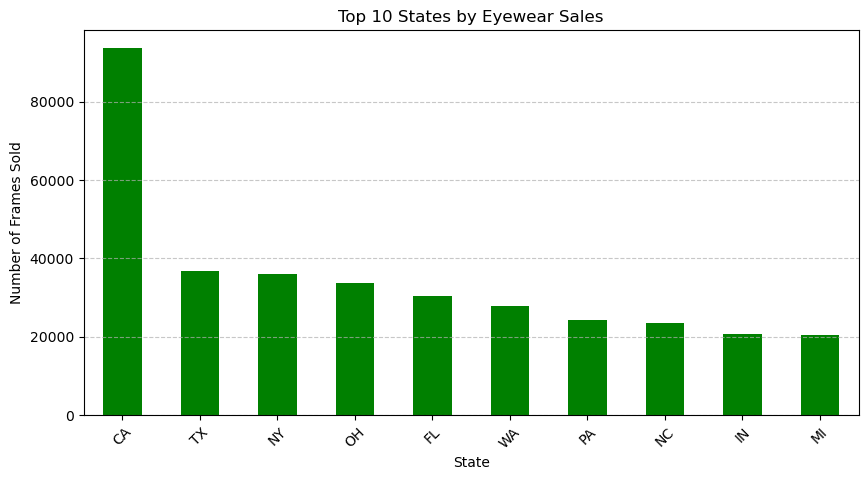

In [32]:
# Count the distribution of frames across states
state_counts = df['state'].value_counts().head(10)  # Top 10 states

# Plot regional distribution
plt.figure(figsize=(10, 5))
state_counts.plot(kind='bar', color='green')
plt.xlabel("State")
plt.ylabel("Number of Frames Sold")
plt.title("Top 10 States by Eyewear Sales")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()